# Personal Information
Name: **Ruben Curiël**

StudentID: **12727431**

Email: [**rzff.curiel@gmail.com**](youremail@student.uva.nl)

Submitted on: **23.3.2025**

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

**CBS**
- Labor participation
- Age
- GDP Composition
- Housing
- Energy Prices

**KNMI**
- Daily temperature
- precipitation
-  wind speed
**Copernicus Climate Datastore**
- SIC
- SC
- SST
- Nao Variablity

**ENTSOE**
- Load Consumption

**World Bank**
- Commodity Price Data (The Pink Sheet)


# Helper functions

Because the research requires several different datasets with differing timeseries notations and other miscellaneous incosistency the following function were created to assist.

In [1]:
import pandas as pd
import re
from ydata_profiling import ProfileReport
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro  # Keep this if needed
import os
import netCDF4 as nc
import pandas as pd
import datetime
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
import math
from math import sqrt
import time
warnings.filterwarnings("ignore")



def Create_Hist_Normal_Plot_With_Stats_Outliers(df):
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_cols)
    
    if num_cols == 0:
        print("No numeric columns to plot.")
        return

    # Create subplots in a single column layout
    fig, axes = plt.subplots(num_cols, 1, figsize=(8, num_cols * 4))
    
    # If there's only one plot, put it in a list for consistency.
    if num_cols == 1:
        axes = [axes]
    
    for i, col in enumerate(numeric_cols):
        # Convert column values to numeric and drop non-convertible values
        data = pd.to_numeric(df[col], errors='coerce').dropna()
        if data.empty:
            axes[i].text(0.5, 0.5, f'No valid numeric data in {col}', ha='center')
            axes[i].set_title(f'Histogram for {col}')
            continue

        # Compute basic statistics
        mean = data.mean()
        median = data.median()
        std = data.std()
        
        # Identify outliers using the IQR method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        
        # Plot the histogram (density normalized)
        axes[i].hist(data, bins=30, density=True, alpha=0.6, color='gray', edgecolor='black')
        
        # Plot the normal curve based on the computed mean and std
        xmin, xmax = data.min(), data.max()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mean, std)
        axes[i].plot(x, p, 'b-', linewidth=2, label='Normal Curve')
        
        # Plot vertical dashed lines for mean and median
        axes[i].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label='Mean')
        axes[i].axvline(median, color='orange', linestyle='dashed', linewidth=1.5, label='Median')
        
        # Perform Shapiro–Wilk test if there are enough data points (at least 3)
        if len(data) >= 3:
            shapiro_stat, shapiro_p = stats.shapiro(data)
            shapiro_text = f"Shapiro: stat={shapiro_stat:.2f}, p={shapiro_p:.4f}"
        else:
            shapiro_text = "Shapiro: Not enough data"
        
        # Create annotation text that includes the statistics and outlier count
        stats_text = f"Mean: {mean:.2f}, Median: {median:.2f}, Std: {std:.2f}"
        outlier_text = f"Outliers: {outlier_count}"
        annotation_text = f"{stats_text}\n{outlier_text}\n{shapiro_text}"
        
        # Annotate below the plot with extra vertical padding (adjust y-coordinate as needed)
        axes[i].text(0.5, -0.30, annotation_text, transform=axes[i].transAxes,
                     ha='center', va='center', fontsize=9,
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        
        # Set the title and legend
        axes[i].set_title(f'Histogram of {col}')
        axes[i].legend()
        
        # Rotate tick labels for readability
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
        for label in axes[i].get_yticklabels():
            label.set_rotation(45)
    
    # Adjust layout to give room for annotations and prevent label overlap
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=1.2)
    plt.show()

def Create_QQ_Plot(df):
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_cols)
    
    if num_cols == 0:
        print("No numeric columns to plot.")
        return

    # Create subplots in a single column layout
    fig, axes = plt.subplots(num_cols, 1, figsize=(8, num_cols * 4))
    
    if num_cols == 1:
        axes = [axes]
    
    # Loop through each numeric column and create a QQ-plot
    for i, col in enumerate(numeric_cols):
        data = pd.to_numeric(df[col], errors='coerce').dropna()
        if data.empty:
            axes[i].text(0.5, 0.5, f'No valid numeric data in {col}', ha='center')
            axes[i].set_title(f'QQ Plot for {col}')
            continue

        # Generate the QQ-plot using statsmodels
        sm.qqplot(data, line='s', ax=axes[i])
        axes[i].set_title(f'QQ Plot of {col}')
        
        # Rotate tick labels for readability
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
        for label in axes[i].get_yticklabels():
            label.set_rotation(45)
    
    # Adjust layout so that the plots are spaced out properly
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.8)
    plt.show()


In [165]:
def convert_to_numeric(df):
    for col in df.select_dtypes(include=['object']).columns:
        # Replace commas with periods and convert to numeric (non-convertible values become NaN)
        df[col] = df[col].str.replace(',', '.')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def extract_int(x):
    digits = re.sub(r'\D', '', x)
    return int(digits) if digits else 0

def convert_quarter_string(s):
    s = s.strip()
    # Expected pattern: "YYYY <number>[optional letter] kwartaal"
    pattern = r"^(\d{4})\s+(\d+)[a-zA-Z]*\s+kwartaal$"
    m = re.fullmatch(pattern, s)
    if m:
        year = m.group(1)
        quarter = m.group(2)
        return pd.Period(f"{year}Q{quarter}", freq='Q')
    else:
        return None

def convert_year_string(s):
    s = s.strip()
    # Expected: exactly a four-digit year.
    m = re.fullmatch(r"\d{4}", s)
    if m:
        return int(s)
    else:
        return None
    
def convert_year_month_string(s):
    # If the value is already a Period, convert it directly.
    if isinstance(s, pd.Period):
        return s.to_timestamp(how='end')
    
    s = str(s).strip().lower()  # Normalize the string (e.g., lowercase for Dutch month names)
    
    # Mapping for Dutch month names to month numbers
    dutch_months = {
        'januari': '01',
        'februari': '02',
        'maart': '03',
        'april': '04',
        'mei': '05',
        'juni': '06',
        'juli': '07',
        'augustus': '08',
        'september': '09',
        'oktober': '10',
        'november': '11',
        'december': '12'
    }
    
    # First, try the direct conversion to a Period with monthly frequency.
    try:
        period_obj = pd.Period(s, freq='M')
        return period_obj
    except Exception:
        pass

    # New branch: try to match format like "1960M02"
    m = re.match(r"(\d{4})m(\d{1,2})", s)
    if m:
        year = int(m.group(1))
        month = int(m.group(2))
        period_obj = pd.Period(f"{year}-{month:02d}", freq='M')
        return period_obj

    # Try to match numeric year-month (formats like "2025-01" or "2025 1")
    m = re.match(r"(\d{4})[-\s]?(\d{1,2})", s)
    if m:
        year = int(m.group(1))
        month = int(m.group(2))
        period_obj = pd.Period(f"{year}-{month:02d}", freq='M')
        return period_obj
    
    # Try to match Dutch month names (formats like "2025 januari")
    m = re.match(r"(\d{4})\s*([a-zA-Z]+)", s)
    if m:
        year = int(m.group(1))
        month_str = m.group(2)
        month_num = dutch_months.get(month_str.lower())
        if month_num:
            period_obj = pd.Period(f"{year}-{month_num}", freq='M')
            return period_obj
    
    # If none of the above worked, return None.
    return None

    
def expand_quarter_to_daily(df, quarter_col=None, use_index=False):

    expanded_rows = []
    
    for idx, row in df.iterrows():
        # Extract the quarter string either from the index or the specified column.
        if use_index:
            quarter_str = str(idx).strip()
        else:
            if quarter_col is None:
                raise ValueError("quarter_col must be provided if use_index is False.")
            quarter_str = str(row[quarter_col]).strip()
        
        # Skip rows that should be dropped.
        if quarter_str == "Bron: CBS":
            continue
        
        period = convert_quarter_string(quarter_str)
        if period is None:
            continue  # Skip rows not matching the expected quarter format.
        
        start_date = period.start_time
        end_date = period.end_time
        
        # Create a daily date range for the quarter.
        daily_index = pd.date_range(start=start_date, end=end_date, freq='D')
        # Duplicate the row for each day.
        row_expanded = pd.DataFrame([row] * len(daily_index), index=daily_index)
        row_expanded['date'] = daily_index
        
        expanded_rows.append(row_expanded)
    
    return pd.concat(expanded_rows) if expanded_rows else pd.DataFrame()



def expand_year_to_daily(df, year_col=None, use_index=False):
    expanded_rows = []
    
    for idx, row in df.iterrows():
        # Extract the year string either from the index or from the specified column.
        if use_index:
            year_str = str(idx).strip()
        else:
            if year_col is None:
                raise ValueError("year_col must be provided if use_index is False.")
            year_str = str(row[year_col]).strip()
        
        year_int = convert_year_string(year_str)
        if year_int is None:
            continue  # Skip rows that do not have a valid year.
        
        start_date = pd.Timestamp(year=year_int, month=1, day=1)
        end_date = pd.Timestamp(year=year_int, month=12, day=31)
        
        # Create a daily date range for the year.
        daily_index = pd.date_range(start=start_date, end=end_date, freq='D')
        # Duplicate the row for each day.
# Convert the row to a dictionary and then create a DataFrame by replicating the dictionary values.
        row_dict = row.to_dict()
        row_expanded = pd.DataFrame({key: [value] * len(daily_index) for key, value in row_dict.items()},
                                    index=daily_index)
        row_expanded['date'] = daily_index
        
        expanded_rows.append(row_expanded)
    
    return pd.concat(expanded_rows) if expanded_rows else pd.DataFrame()

def expand_halfjaar_to_months(period):
    """
    Expands a half-year period string into a list of monthly strings in 'YYYY-MM' format.
    """
    parts = period.split()
    if len(parts) < 2:
        raise ValueError("Invalid period format. Expected 'YYYY Xe ...'.")
    
    year_str, half_indicator = parts[0], parts[1]
    year = int(year_str)
    
    if half_indicator.startswith('1e'):
        start_month, end_month = 1, 6
    elif half_indicator.startswith('2e'):
        start_month, end_month = 7, 12
    else:
        raise ValueError(f"Unrecognized half identifier: '{half_indicator}'.")
    
    return [f"{year}-{month:02d}" for month in range(start_month, end_month + 1)]

def expand_year_month_to_daily(df, year_month_col=None, use_index=False):
    expanded_rows = []

    for idx, row in df.iterrows():
        # Extract the year-month string either from index or a specified column.
        if use_index:
            year_month_str = str(idx).strip()
        else:
            if year_month_col is None:
                raise ValueError("year_month_col must be provided if use_index is False")
            year_month_str = str(row[year_month_col]).strip()
        
        period = convert_year_month_string(year_month_str)
        if period is None:
            continue  # Skip rows that don't have a valid year-month
        
        # Determine start and end dates for the month.
        start_date = period.start_time  # first day of the month
        end_date = period.end_time      # last day of the month

        # Create a daily date range for that month.
        daily_index = pd.date_range(start=start_date, end=end_date, freq='D')
        
        # Duplicate the row for each day.
        # Instead of repeating the row (which can cause duplicate-index issues),
        # we create a dictionary with each column's value repeated.
        row_dict = row.to_dict()
        daily_df = pd.DataFrame({key: [value] * len(daily_index) for key, value in row_dict.items()},
                                index=daily_index)
        # Optionally add a 'date' column.
        daily_df['date'] = daily_index
        
        expanded_rows.append(daily_df)
    
    if expanded_rows:
        return pd.concat(expanded_rows)
    else:
        return pd.DataFrame()

import pandas as pd

def read_data(path: str) -> pd.DataFrame:
    """
    Read the data.
    Strip spaces from the columns.
    Rename all the columns (abbreviations -> full names).
    """

    weather = pd.read_csv(path)

    weather.columns = weather.columns.str.strip()
    weather = weather.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    weather.replace('', None, inplace=True)

    column_mapping = {
        'YYYYMMDD': 'Date',
        'RH': 'DailyPrecipitation',
        'RHX': 'MaxHourlyPrecipitation',
        'RHXH': 'HDMaxPrecipitation',
        'TG': 'DailyMeanTemperature',
        'TN': 'HourlyMinTemperature',
        'TNH': 'HDMinTemperature',
        'TX': 'HourlyMaxTemperature',
        'TXH': 'HDMaxTemperature',
        'FG': 'DailyMeanWindspeed',
        'FHX': 'MaxHourlyMeanWindspeed',
        'FHXH': 'HDMaxMeanWindspeed',
        'FHN': 'MinHourlyMeanWindspeed',
        'FHNH': 'HDMinMeanWindspeed'
    }

    weather = weather[column_mapping.keys()]
    weather.rename(columns=column_mapping, inplace=True)

    return weather


def filter_on_year(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Filter on only 2021 and later and reset index after filtering.
    """
    weather = weather[weather['Date'] >= 20210101]
    weather.reset_index(drop=True, inplace=True)

    return weather


def cast_datekey(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast datekey 20210101 to format 2021/01/01
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.strftime('%Y/%m/%d')

    return weather


def cast_hour_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast hour columns to integer.
    """
    hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    for i in hour_cols:
        weather[i] = weather[i].astype(int)

    return weather


def convert_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Divide the following columns by 10 to get actual number, since they are 0.1 of the actual number.
    """
    cols_to_convert = [
        'DailyPrecipitation',
        'MaxHourlyPrecipitation',
        'DailyMeanTemperature',
        'HourlyMaxTemperature',
        'DailyMeanWindspeed',
        'MinHourlyMeanWindspeed',
        'MaxHourlyMeanWindspeed'
    ]
    for i in cols_to_convert:
        weather[i] = weather[i] / 10

    return weather


def create_date_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast date column (2021-01-01 instead of 2021/01/01) and add month and year columns
    Create a week key combining year and week number
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y/%m/%d')
    weather['Month'] = weather['Date'].dt.month
    weather['Year'] = weather['Date'].dt.year
    weather['Week'] = weather['Date'].dt.isocalendar().week

    weather['WeekKey'] = weather['Year'].astype(str) + weather['Week'].apply(lambda x: '{:02d}'.format(x))
    weather['day_of_week'] = weather['Date'].dt.day_name()

    return weather


def preprocess_weather(path: str) -> pd.DataFrame:
    """
    Preprocess the weather data.
    """
    weather = read_data(path)
    weather = filter_on_year(weather)
    weather = cast_datekey(weather)
    weather = cast_hour_columns(weather)
    weather = convert_columns(weather)
    weather = create_date_columns(weather)

    return weather


import pandas as pd


def preprocess_nao(path: str) -> pd.DataFrame:
    """
    Reset index, index is now the year and we want this as a column.
    Melt the dataset into a year, month and NAO column.
    Rename index to Year.
    Map the months (now strings) to corresponding month numbers.
    """
    nao = pd.read_csv(path, delim_whitespace=True, index_col=0)
    nao.reset_index(inplace=True)
    nao_melted = pd.melt(nao, id_vars=['index'], var_name='Month', value_name='NAO')
    nao_melted.rename(columns={'index':'Year'}, inplace=True)
    month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    nao_melted['Month'] = nao_melted['Month'].map(month_mapping)

    return nao_melted

import pandas as pd


def add_datetime_columns(df):
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Initialize datetime_index
    datetime_index = None
    
    # Check if the index is a PeriodIndex
    if isinstance(df.index, pd.PeriodIndex):
        datetime_index = df.index.to_timestamp()
    else:
        # Check if the index contains Period objects (for non-empty index)
        if df.index.size > 0 and isinstance(df.index[0], pd.Period):
            datetime_index = pd.DatetimeIndex([p.to_timestamp() for p in df.index])
        else:
            # Convert the index to datetime using pandas to_datetime
            datetime_index = pd.to_datetime(df.index)
    
    # Extract each component and assign to new columns
    df['Year'] = datetime_index.year
    df['Month'] = datetime_index.month
    df['Day'] = datetime_index.day
    df['Hour'] = datetime_index.hour
    df['Minute'] = datetime_index.minute
    
    for col in ['Year','Month','Day','Hour','Minute']:
        df[col] = df[col].astype('Int64')
    return df


def check_missing_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Checks for rows with NaN, empty strings, or whitespace-only strings.
    Returns a DataFrame with the original index and a 'has_missing' boolean column.
    """
    # Check for NaN/None
    na_mask = df.isnull()
    
    # Check for empty strings
    empty_str_mask = (df == '')
    
    # Check for whitespace-only strings (SAFELY, without .strip() on non-strings)
    whitespace_mask = df.applymap(lambda x: 
        isinstance(x, str) and (x.strip() == '')  # <-- Check if string FIRST
    )
    
    # Combine masks
    combined_mask = na_mask | empty_str_mask | whitespace_mask
    
    # Check row-wise
    has_missing = combined_mask.any(axis=1)
    
    # Return with column name
    return has_missing.to_frame(name='has_missing')

def get_rows_with_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns rows from the original DataFrame where any missing values are detected.
    """
    has_missing = check_missing_rows(df)['has_missing']
    return df[has_missing]


In [3]:
def Create_EDA(df):    
    # Check for missing values
    missing_report = check_missing_rows(df)

    # Get rows with missing values (for potential inspection)
    df_missing_rows = df[missing_report['has_missing']]

    # Print statistics
    print(f'Amount of days with missing values: {df.isna().sum() / len(df)}')
    print('\nDescriptives of labor participation:\n')
    print(df.describe())
    print('\n' + '-'*50 + '\n')

    # Generate plots
    print('Distribution and QQ plots:\n')
    QQ_plots = Create_QQ_Plot(df)
    Distribution_Plots = Create_Hist_Normal_Plot_With_Stats_Outliers(df)

    # Display plots (if not automatically rendered)
    plt.show()

# Preprocessing

Since I will am using alot of datasets that need to be combined I Needed to make all the datasets as uniform as possible. This is done by
1. Checking all the datasets on completeness, since most of the data is from the CBS is fairly clean already
    - To do so i used descriptives, QQ-plots and distributions to find anomalies
2. Create datetime values to eventually merge on. Since the Loadconsumption used a Column for Year, Month Day Hour and Minute I recreated this for the other datasets as well 

**Labor participation**

Amount of days with missing values: Beroepsbevolking|werkloze beroepsbevolking|Werkloze beroepsbevolking    0.0
Beroepsbevolking|werkloze beroepsbevolking|Kortdurig                    0.0
Beroepsbevolking|werkloze beroepsbevolking|Langdurig of onbekend        0.0
Beroepsbevolking|Werkloosheidspercentage                                0.0
dtype: float64

Descriptives of labor participation:

       Beroepsbevolking|werkloze beroepsbevolking|Werkloze beroepsbevolking  \
count                                          48.000000                      
mean                                          522.354167                      
std                                           155.867441                      
min                                           327.000000                      
25%                                           374.000000                      
50%                                           461.000000                      
75%                                           689.000

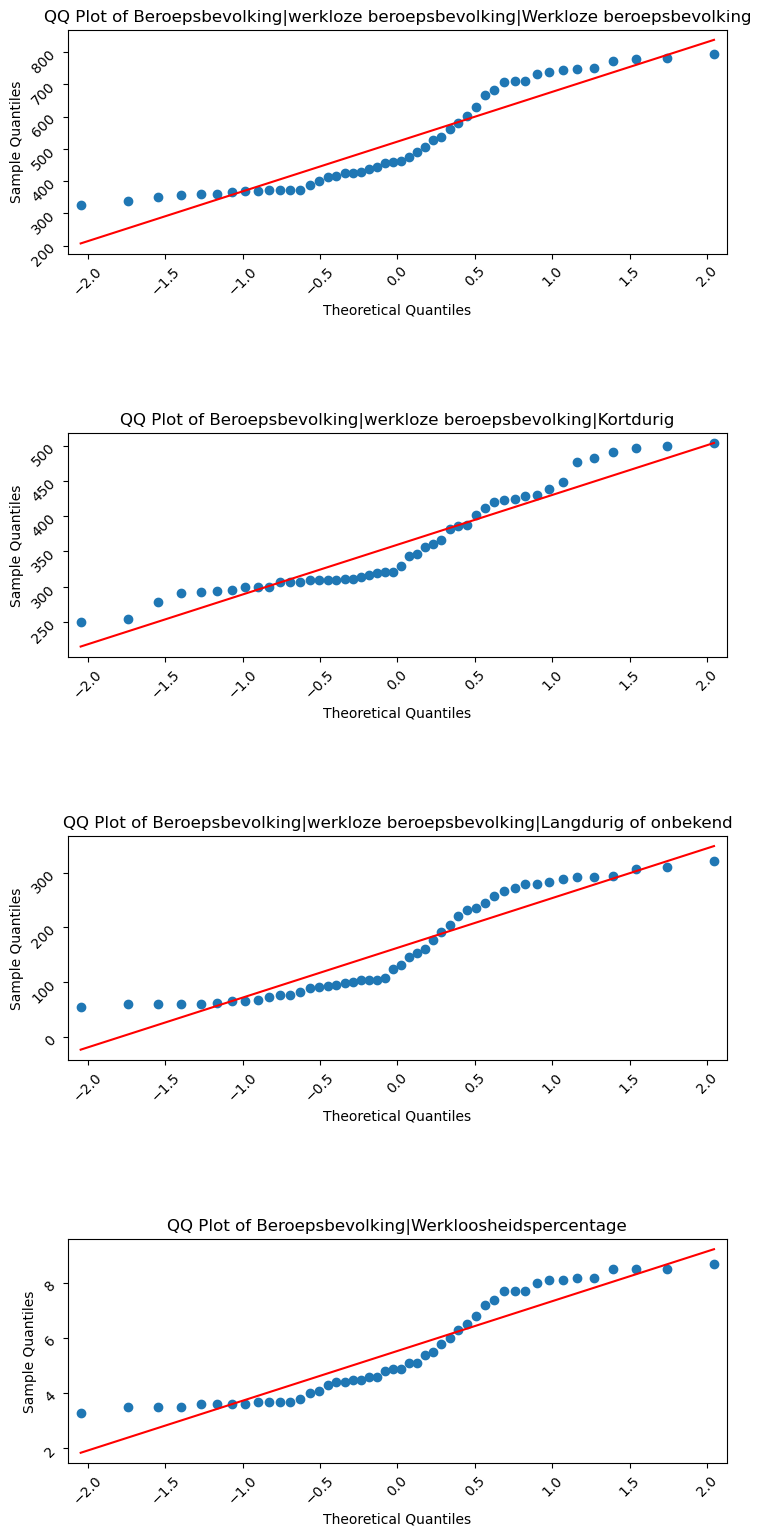

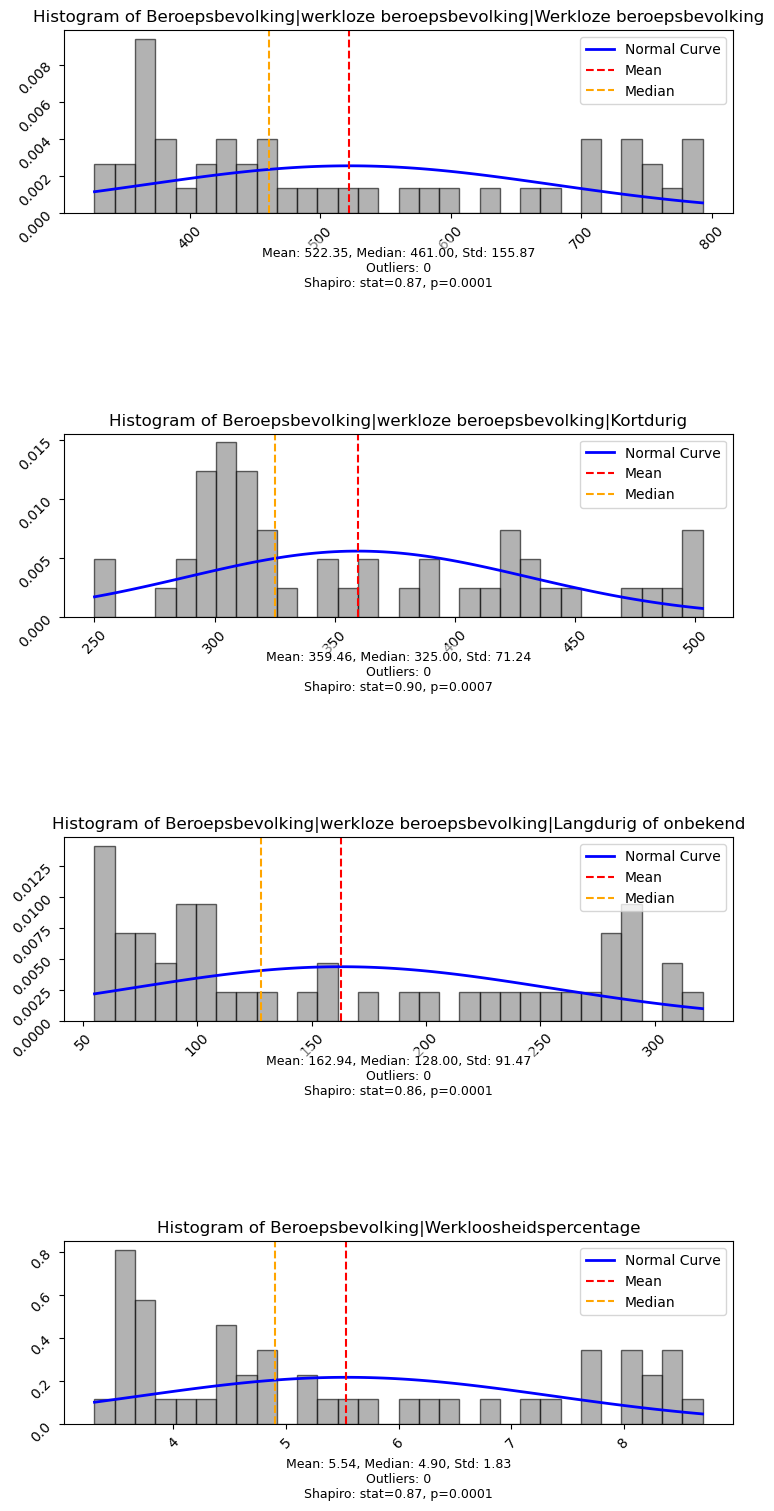

In [33]:

# Non percentage values are /1000 of real value. 
LaborParticipation = pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/CBS/Arbeidsdeelname__kerncijfers_seizoengecorrigeerd_21022025_095354.csv',
sep=';', header=3)


LaborParticipation = LaborParticipation.drop([0])


# #generating a report
def LaborParticipationPreprocess(LaborParticipation):
    LaborParticipation['Unnamed: 0'] = LaborParticipation['Unnamed: 0'].apply(lambda x: convert_quarter_string(x))
    LaborParticipation['Unnamed: 0'] = (
        pd.PeriodIndex(LaborParticipation['Unnamed: 0'], freq="Q")
        .to_timestamp()  # Converts Period to datetime
    )
    LaborParticipation.set_index('Unnamed: 0', inplace=True)
    LaborParticipation.index.names = ['Date']
    # In the data full years could be skipped, due to the conversion these became null thus we can drop them
    LaborParticipation = LaborParticipation[LaborParticipation.index.notnull()]
    LaborParticipation['Beroepsbevolking|Werkloosheidspercentage'] = LaborParticipation['Beroepsbevolking|Werkloosheidspercentage'].astype(str).str.replace(',', '.')
    LaborParticipation = LaborParticipation.apply(pd.to_numeric, errors='coerce')
    return LaborParticipation


df_LaborParticipation = LaborParticipationPreprocess(LaborParticipation)

Create_EDA(df_LaborParticipation)







**Consumer price index**

Nan Values can be explained due to the fact Jaarmutatie was only calculated from 1997 onwards, therefore for the eventual data set the start date will be 1997-1-1

Amount of days with missing values: CPI | 2015 = 100                0.002639
CPI afgeleid | 2015 = 100       0.002639
Jaarmutatie CPI | %             0.036939
Jaarmutatie CPI afgeleid | %    0.036939
dtype: float64

Descriptives of labor participation:

       CPI | 2015 = 100  CPI afgeleid | 2015 = 100  Jaarmutatie CPI | %  \
count        378.000000                 378.000000           365.000000   
mean          93.499471                  94.936825             2.321918   
std           16.062551                  14.232265             1.899410   
min           68.030000                  72.280000            -0.400000   
25%           82.265000                  85.115000             1.300000   
50%           91.745000                  93.850000             2.000000   
75%          102.022500                 101.962500             2.700000   
max          132.260000                 129.680000            14.500000   

       Jaarmutatie CPI afgeleid | %  
count                    365.000

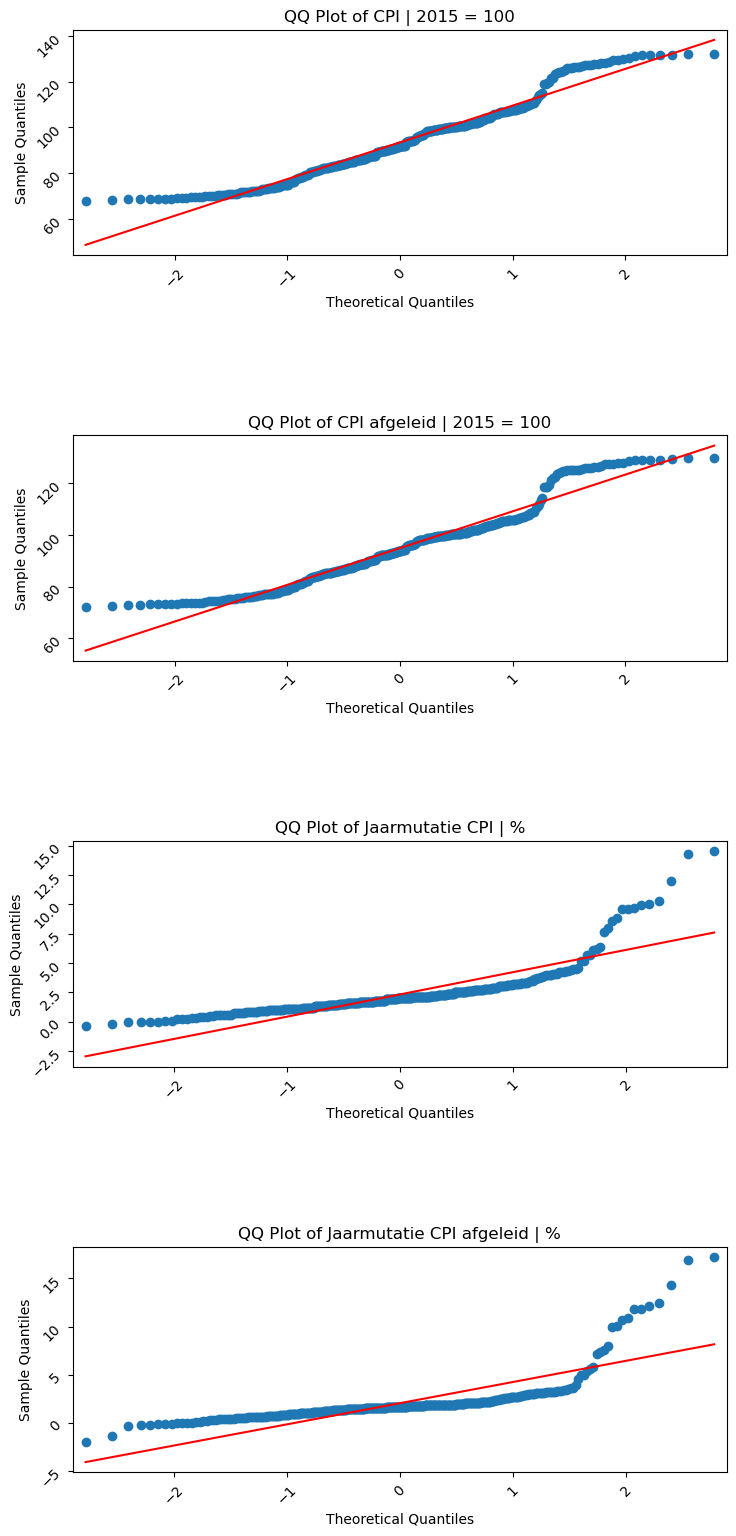

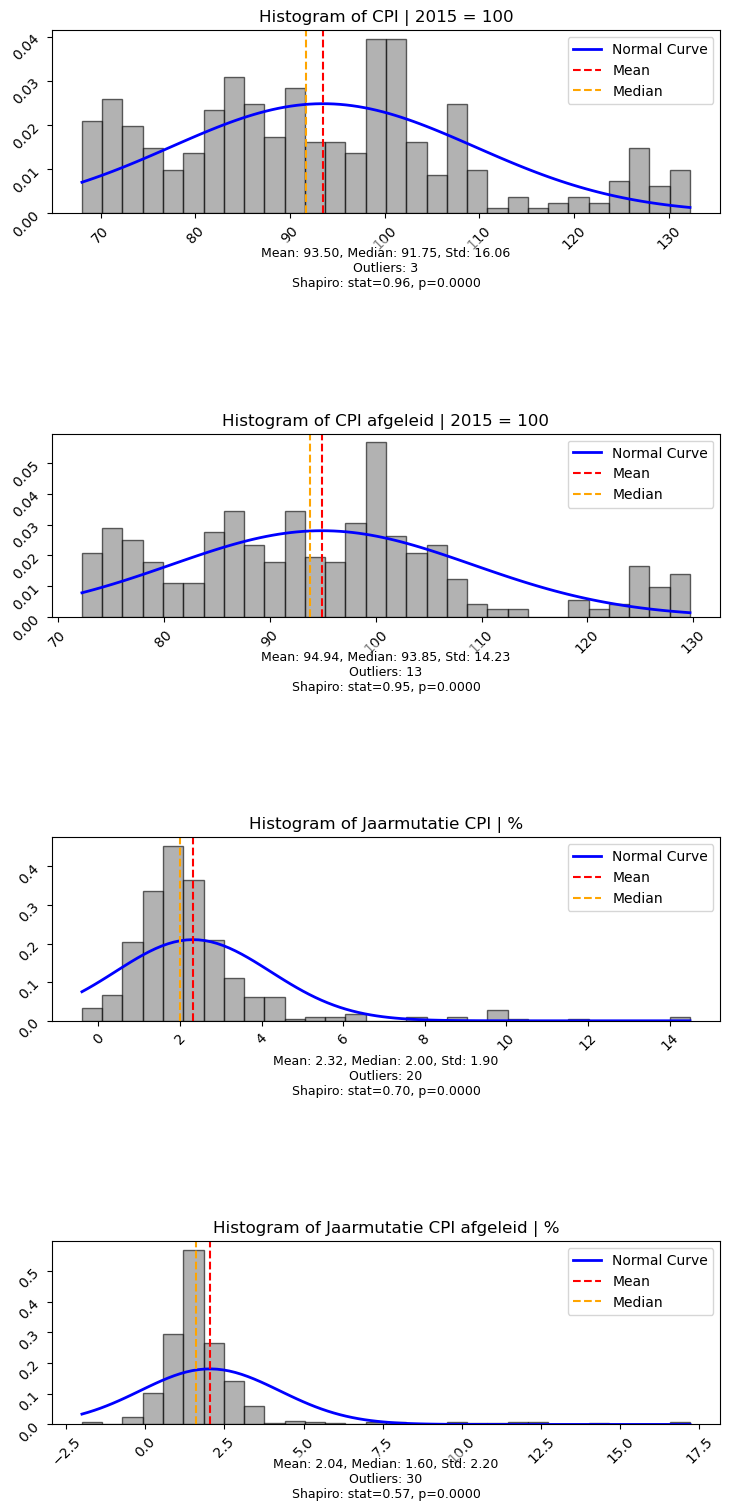

In [35]:
ConsumerPriceIndex = pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/CBS/Consumentenprijzen__prijsindex_2015_100_01032025_140302.csv',sep=';', header=3)
ConsumerPriceIndex.drop([0])

def ConsumerPriceIndexPreprocess(ConsumerPriceIndex):
    ConsumerPriceIndex.columns += ' | ' + ConsumerPriceIndex.iloc[0]
    ConsumerPriceIndex = ConsumerPriceIndex.drop(0)
    
    ConsumerPriceIndex['Unnamed: 0 | Perioden'] = ConsumerPriceIndex['Unnamed: 0 | Perioden'].apply(lambda x: convert_year_month_string(x))
    ConsumerPriceIndex.set_index(['Unnamed: 0 | Perioden'], inplace=True)
    ConsumerPriceIndex.index.names = ['Date']
    ConsumerPriceIndex = convert_to_numeric(ConsumerPriceIndex)
    return ConsumerPriceIndex

# ConsumerPriceIndexPreprocess(ConsumerPriceIndex)
df_ConsumerPriceIndex = ConsumerPriceIndexPreprocess(ConsumerPriceIndex)
df_ConsumerPriceIndex.index.to_timestamp

Create_EDA(df_ConsumerPriceIndex)

**Population Size**

In [178]:
PopulationSize = pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/CBS/Bevolking_op_1_januari_en_gemiddeld__geslacht__leeftijd_en_regio_23022025_161215.csv',sep=';',header=3)
PopulationSize = PopulationSize.drop(['Unnamed: 0'],axis=1)

      
def PopulationSizePreprocess(PopulationSize,string):
    df = PopulationSize
    df = df.set_index('Onderwerp')
    # Filter columns where the column label contains the substring (case-insensitive)
    df_filtered = df.loc[:, df.columns.str.contains(string, case=False, na=False)]
    # Set the column names to the values in row at index 2
    df_filtered.columns = df_filtered.iloc[2]

    # Drop the first three rows (rows 0, 1, and the row we just used as headers)
    df_filtered = df_filtered.iloc[3:]
    df_filtered.index.names = ['Date']

    df_filtered.columns =  df_filtered.columns.map(extract_int)
    df_filtered = df_filtered.drop(index=['Perioden'])
    df_filtered.rename(index={'Leeftijd':''}, inplace=True)
    df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

    return df_filtered



df = PopulationSizePreprocess(PopulationSize,'1 januari')


df = df.drop(df.columns[[0]], axis=1)

duplicate_mask = df.columns.duplicated()
print("Duplicate columns:")
print(df.columns[duplicate_mask])
mask = (df.columns <= 94) | (np.isnan(df.columns))

# Filter the DataFrame based on the mask.
df_PopulationSize = df.loc[:, mask]




df_PopulationSize = df_PopulationSize.loc[:, ~df_PopulationSize.columns.duplicated()]


age_cols = sorted(col for col in df_PopulationSize.columns 
                  if isinstance(col, int) and col <= 94)
df_age = df_PopulationSize[age_cols]


df_PopulationSize['Total'] = df_age.sum(axis=1)


df_PopulationSize['MeanAge'] = (df_age.mul(age_cols, axis=1).sum(axis=1)
                                / df_PopulationSize['Total'])


def weighted_median(row):
    total = row.sum()
    if total == 0:
        return np.nan
    cum = row.sort_index().cumsum()
    return cum.index[cum >= total/2][0]

df_PopulationSize['MedianAge'] = df_age.apply(weighted_median, axis=1)


means = df_PopulationSize['MeanAge'].values.reshape(-1, 1)
df_PopulationSize['StdAge'] = np.sqrt(
    df_age.mul((age_cols - means)**2, axis=1).sum(axis=1) 
    / df_PopulationSize['Total']
)

df_PopulationSize = df_PopulationSize[['Total','MeanAge','MedianAge','StdAge']]
df_PopulationSize = expand_year_to_daily(df_PopulationSize,use_index=True)
df_PopulationSize.head()


Duplicate columns:
Index([95], dtype='int64', name='Leeftijd')


Total    MeanAge  MedianAge     StdAge       date
1988-01-01  14520378.0  36.169938       34.0  21.535614 1988-01-01
1988-01-02  14520378.0  36.169938       34.0  21.535614 1988-01-02
1988-01-03  14520378.0  36.169938       34.0  21.535614 1988-01-03
1988-01-04  14520378.0  36.169938       34.0  21.535614 1988-01-04
1988-01-05  14520378.0  36.169938       34.0  21.535614 1988-01-05

For Age the nan values can be explained due to the increased life expectancy of people so older age were less common in the starting years of the dataset. Therefore it might be wiser to use the mean, median and sd of age per year as indicator rather than the ages on an individual bases.

Gdp

Amount of days with missing values: Unnamed: 0
Bbp vanuit de finale bestedingen|Waarde in werkelijke prijzen|Invoer van goederen en diensten (-)|Totaal      0.0
Bbp vanuit de finale bestedingen|Waarde in werkelijke prijzen|Invoer van goederen en diensten (-)|Goederen    0.0
Bbp vanuit de finale bestedingen|Waarde in werkelijke prijzen|Invoer van goederen en diensten (-)|Diensten    0.0
Bbp vanuit de finale bestedingen|Waarde in werkelijke prijzen|Bruto binnenlands product                       0.0
dtype: float64

Descriptives of labor participation:

Unnamed: 0  Bbp vanuit de finale bestedingen|Waarde in werkelijke prijzen|Invoer van goederen en diensten (-)|Totaal  \
count                                               28.000000                                                          
mean                                            393949.964286                                                          
std                                             155646.527656                      

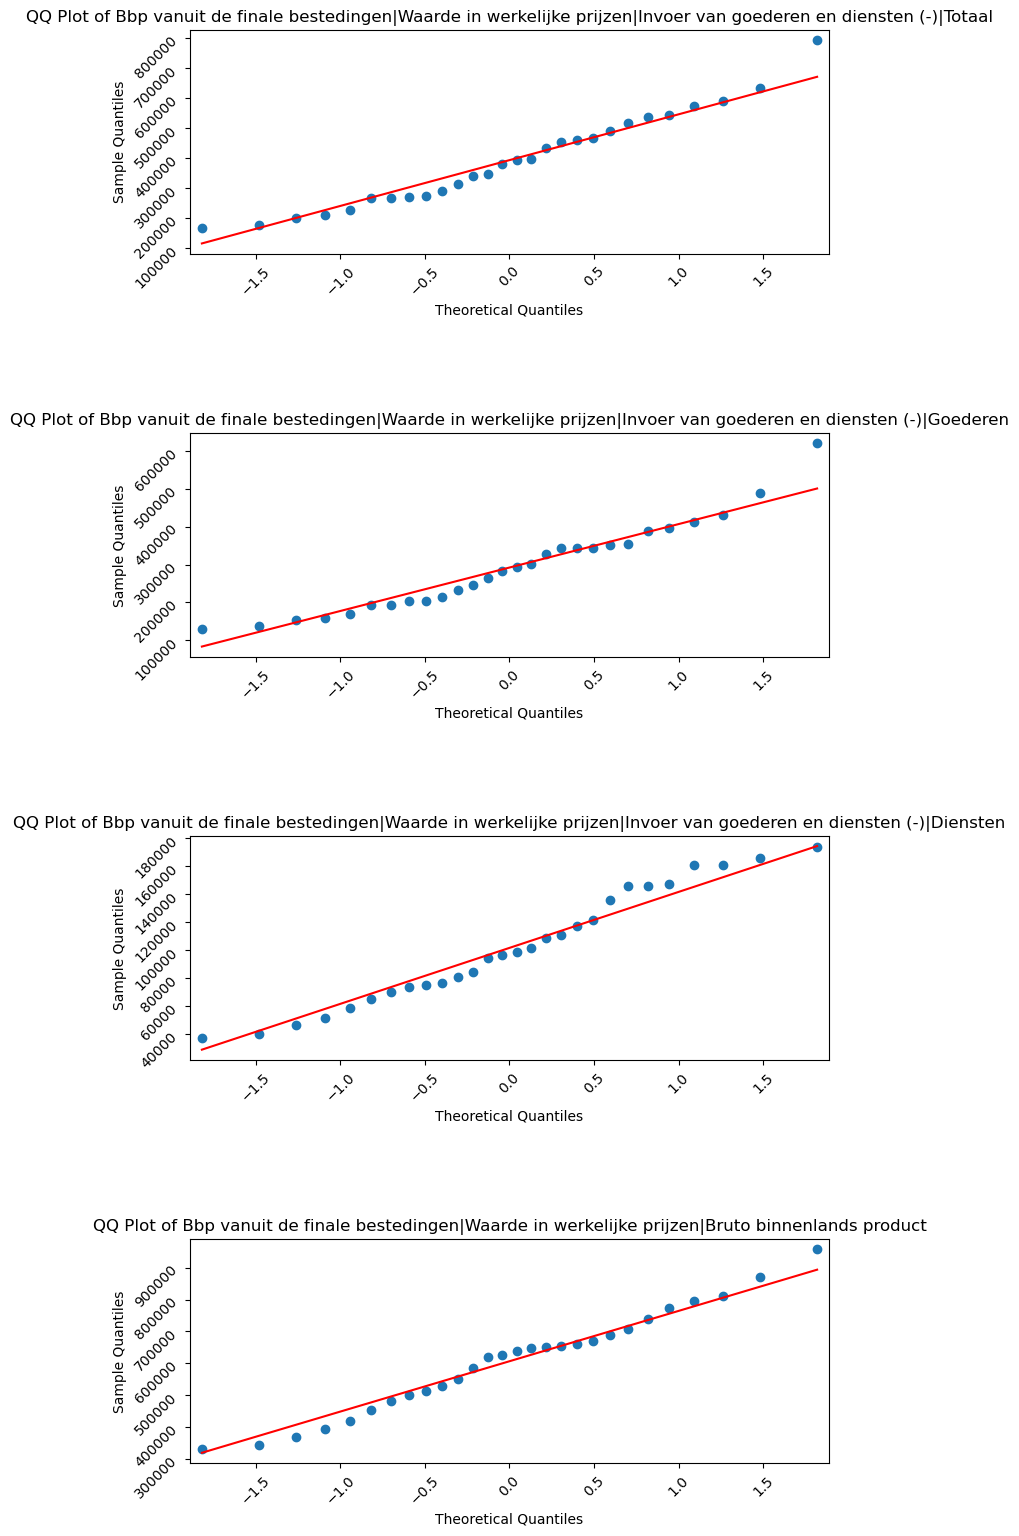

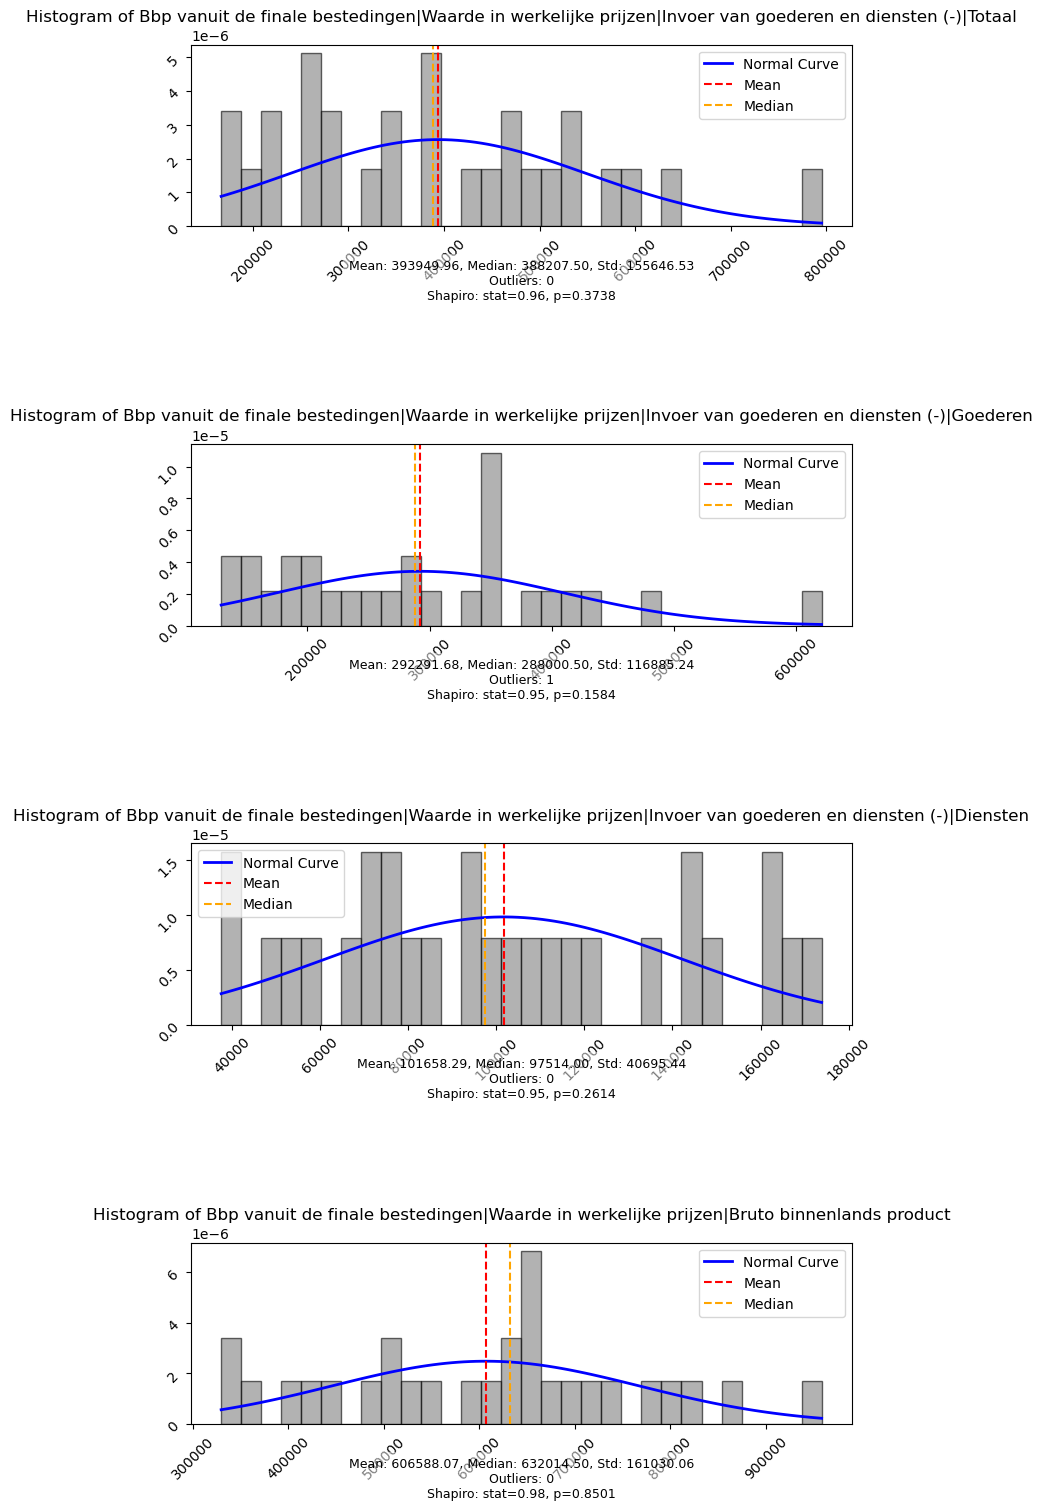

In [132]:
Gdp = pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/CBS/Opbouw_binnenlands_product__bbp___nationale_rekeningen__1995_2022_28022025_221707.csv',sep=';', header=2).T
Gdp.columns = Gdp.iloc[0]
Gdp = Gdp.reset_index(drop=True)
Gdp = Gdp.drop(columns=['Bron: CBS'])
Gdp = Gdp.drop([0,1])
Gdp = Gdp.rename(columns={'Onderwerp':'Date'})
Gdp.set_index("Date", inplace=True)
Gdp.index = Gdp.index = pd.to_datetime(
    Gdp.index.astype(int),  # Convert float to integer first
    format='%Y'             # Format specifier for 4-digit years
)
Gdp = Gdp.apply(pd.to_numeric, errors='coerce')

Create_EDA(Gdp)



**GDP Composition**

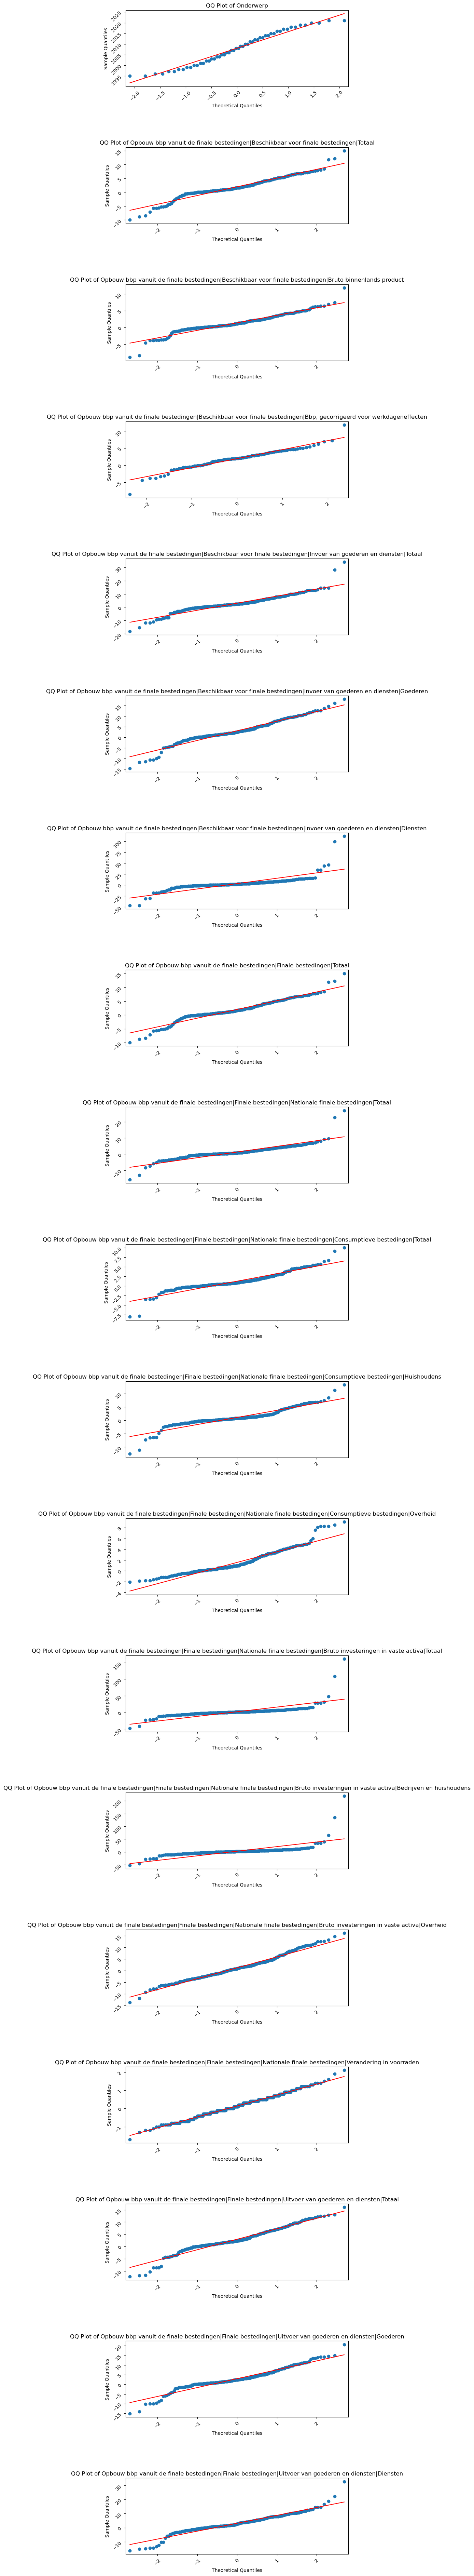

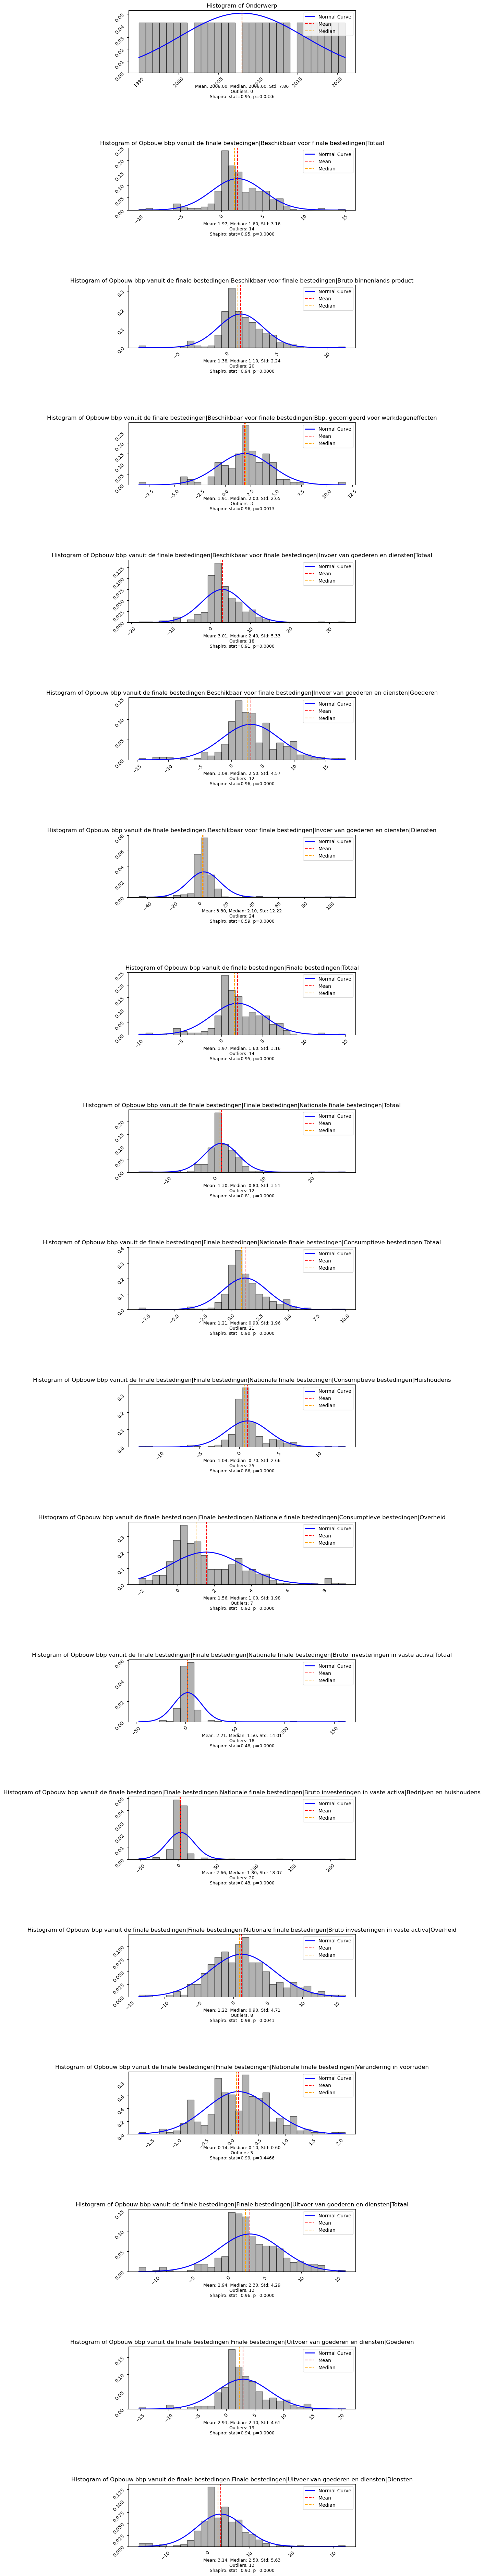

Index(['Opbouw bbp vanuit de finale bestedingen|Beschikbaar voor finale bestedingen|Totaal',
       'Opbouw bbp vanuit de finale bestedingen|Beschikbaar voor finale bestedingen|Bruto binnenlands product',
       'Opbouw bbp vanuit de finale bestedingen|Beschikbaar voor finale bestedingen|Bbp, gecorrigeerd voor werkdageneffecten',
       'Opbouw bbp vanuit de finale bestedingen|Beschikbaar voor finale bestedingen|Invoer van goederen en diensten|Totaal',
       'Opbouw bbp vanuit de finale bestedingen|Beschikbaar voor finale bestedingen|Invoer van goederen en diensten|Goederen',
       'Opbouw bbp vanuit de finale bestedingen|Beschikbaar voor finale bestedingen|Invoer van goederen en diensten|Diensten',
       'Opbouw bbp vanuit de finale bestedingen|Finale bestedingen|Totaal',
       'Opbouw bbp vanuit de finale bestedingen|Finale bestedingen|Nationale finale bestedingen|Totaal',
       'Opbouw bbp vanuit de finale bestedingen|Finale bestedingen|Nationale finale bestedingen|Consumptieve

In [205]:
GdpProductionAndSpending = pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/CBS/Bbp__productie_en_bestedingen__kwartalen__mutaties__na__1995__2024_I_28022025_214426.csv',sep=';', header=3).T
GdpProductionAndSpending = GdpProductionAndSpending.reset_index(drop=True)
# set header of
GdpProductionAndSpending.columns = GdpProductionAndSpending.iloc[0]

GdpProductionAndSpending = GdpProductionAndSpending.drop('Bron: CBS', axis=1)   
GdpProductionAndSpending_daily = expand_quarter_to_daily(GdpProductionAndSpending, 'Onderwerp')

GdpProductionAndSpending = convert_to_numeric(GdpProductionAndSpending)
GdpProductionAndSpending = GdpProductionAndSpending.apply(pd.to_numeric, errors='coerce')

df_GdpProductionAndSpending = GdpProductionAndSpending_daily.drop(['Onderwerp','date'],axis=1)
df_GdpProductionAndSpending = convert_to_numeric(df_GdpProductionAndSpending)



df_GdpProductionAndSpending.index.names = ['Date']


GdpProductionAndSpending_QQ_Plots = Create_QQ_Plot(GdpProductionAndSpending)
GdpProductionAndSpending_Distribution_Plots = Create_Hist_Normal_Plot_With_Stats_Outliers(GdpProductionAndSpending) 
df_GdpProductionAndSpending.columns

For GdpProductionAndSpending the data registration also only started in 1996, but do the the conversion to a daily a higher nan ratio was recorded. Therefore the start of this dataset will be set on 1996-1-1

**Housing**

Amount of days with missing values: Prijsindex verkoopprijzen|Prijsindex bestaande koopwoningen          0.002646
Prijsindex verkoopprijzen|Ontwikkeling  t.o.v. voorgaande periode    0.007937
Prijsindex verkoopprijzen|Ontwikkeling  t.o.v. een jaar eerder       0.037037
Aantal verkochte woningen|Aantal verkochte woningen                  0.002646
Aantal verkochte woningen|Ontwikkeling  t.o.v. voorgaande periode    0.007937
Aantal verkochte woningen|Ontwikkeling  t.o.v. een jaar eerder       0.037037
Gemiddelde verkoopprijs                                              0.002646
Totale waarde verkoopprijzen                                         0.002646
dtype: float64

Descriptives of labor participation:

       Prijsindex verkoopprijzen|Prijsindex bestaande koopwoningen  \
count                                         377.000000             
mean                                          105.791777             
std                                            34.063191             
min   

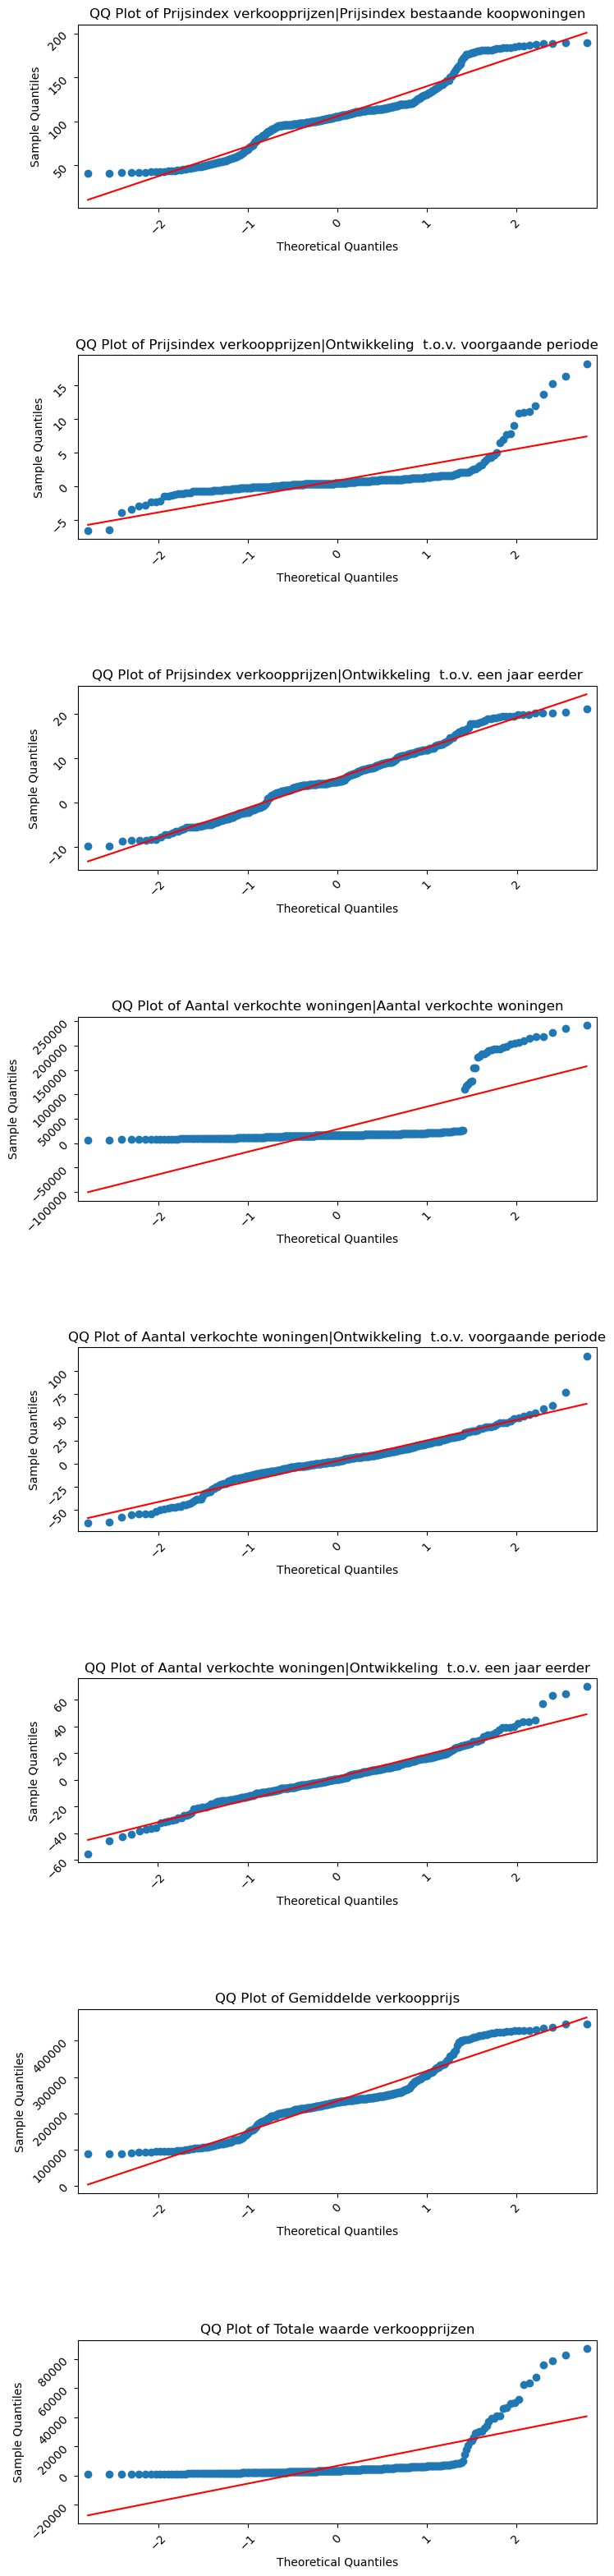

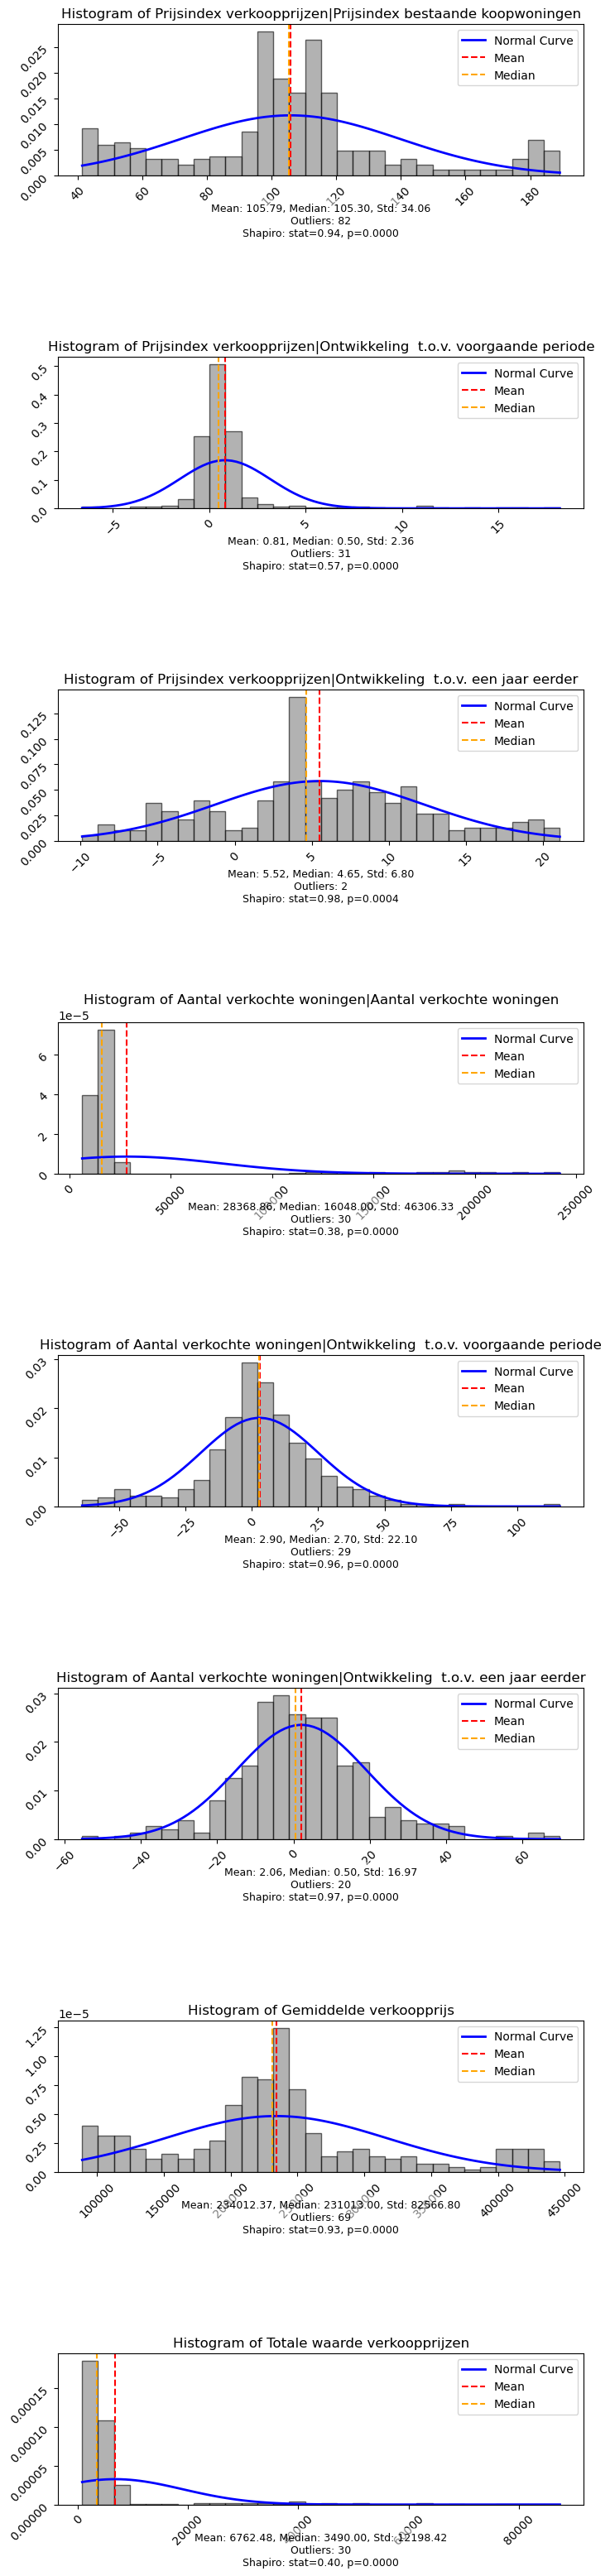

In [206]:


Boughthomes =  pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/CBS/Bestaande_koopwoningen__verkoopprijzen_prijsindex_2015_100_1995_2023_25022025_192415.csv',sep=';', header=3)

# Boughthomes_daily = expand_year_month_to_daily(Boughthomes, year_month_col="Unnamed: 0")
Boughthomes['Unnamed: 0'] = Boughthomes['Unnamed: 0'].apply(lambda x: convert_year_month_string(x))
Boughthomes.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
Boughthomes.set_index(['Date'], inplace=True)
Boughthomes = Boughthomes.iloc[1:]
Boughthomes = convert_to_numeric(Boughthomes)
df_Boughthomes = Boughthomes.apply(pd.to_numeric, errors='coerce')

Create_EDA(df_Boughthomes)






For the bought houses the nans are explained because the column Aantal verkochte woningen|Ontwikkeling  t.o.v. een jaar eerder, take the prices of the previous year and compares them to next year. Thus the start year has nan values.

**Commodities**

Amount of days with missing values: Crude oil, average | ($/bbl)                0.000000
Crude oil, Brent | ($/bbl)                  0.000000
Crude oil, Dubai | ($/bbl)                  0.000000
Crude oil, WTI | ($/bbl)                    0.338462
Coal, Australian | ($/mt)                   0.153846
Coal, South African ** | ($/mt)             0.369231
Natural gas, US | ($/mmbtu)                 0.000000
Natural gas, Europe | ($/mmbtu)             0.000000
Liquefied natural gas, Japan | ($/mmbtu)    0.261538
Natural gas index | (2010=100)              0.261538
dtype: float64

Descriptives of labor participation:

       Crude oil, average | ($/bbl)  Crude oil, Brent | ($/bbl)  \
count                    780.000000                  780.000000   
mean                      33.412984                   34.230560   
std                       31.357458                   32.522904   
min                        1.210000                    1.210000   
25%                       11.510000          

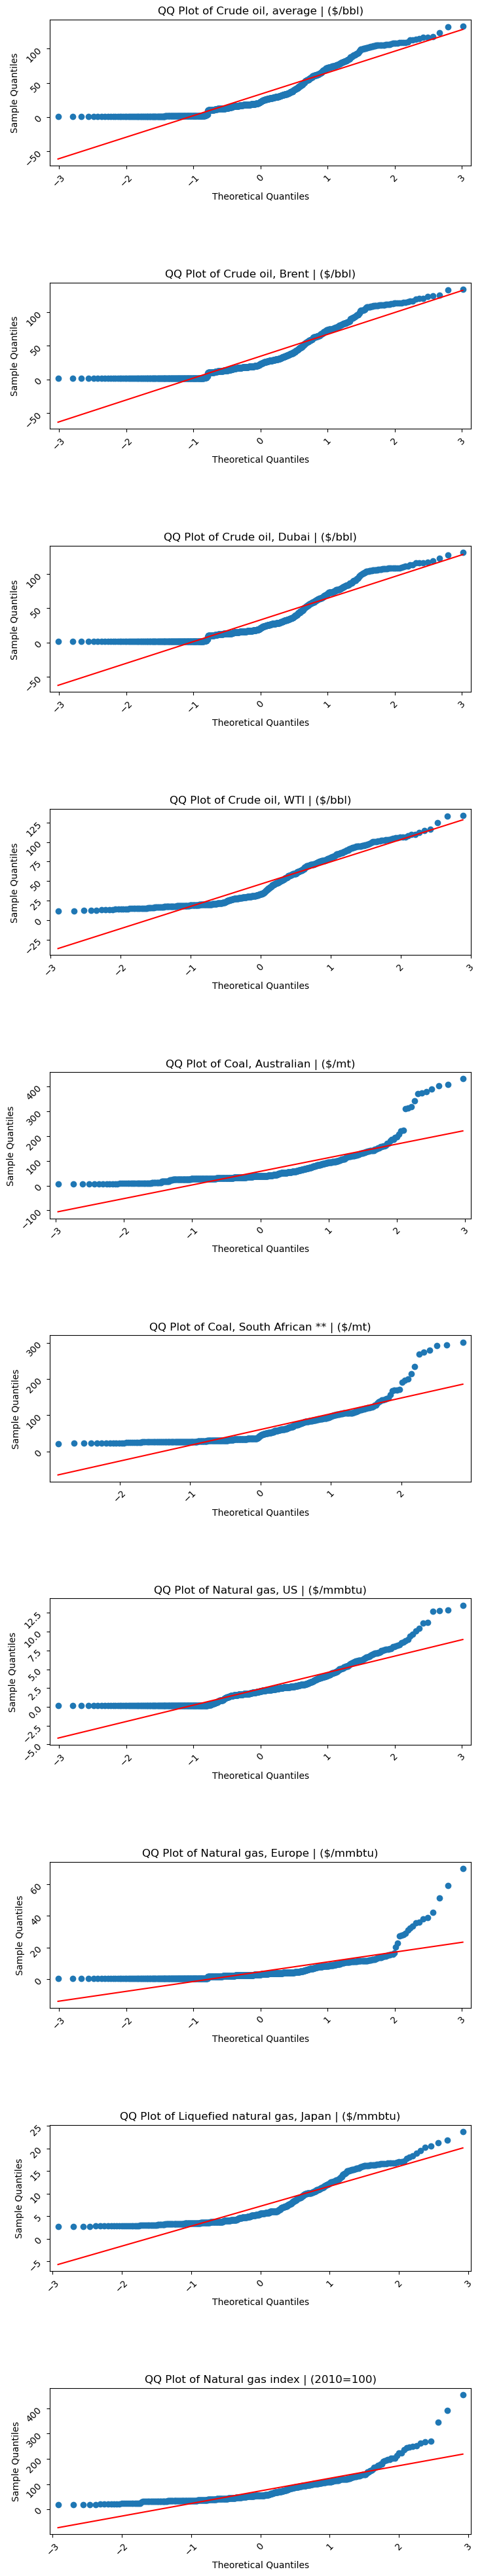

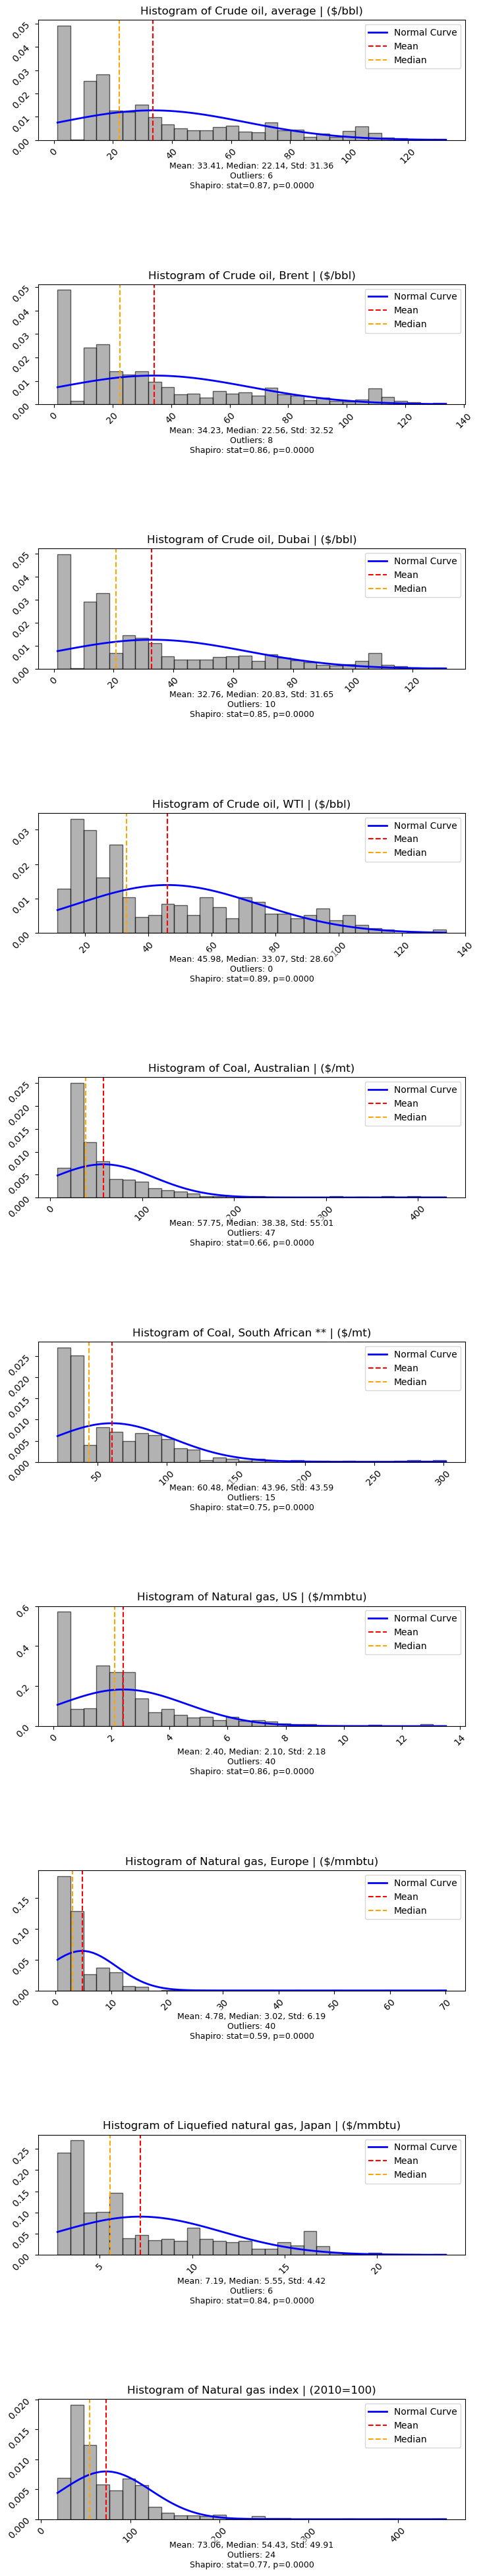

In [207]:
def find_columns_energy_commodities(df):
    # Define a pattern that matches any of the keywords
    pattern = r"(Coal|Coal (Colombia)|Coal (South Africa)|Crude oil| index (Laspeyres)|Natural Gas|natural gas)"
    # Use a list comprehension to check each column name
    matching_columns = [col for col in df.columns if re.search(pattern, str(col), re.IGNORECASE)]

    return matching_columns

# Commodities_daily = expand_year_month_to_daily(Commodities, year_month_col="Unnamed: 0")
# Commodities_daily.drop(['Unnamed: 0','date'],axis=1,inplace=True)
Commodities = pd.read_excel('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/Commodity Future Data/CMO/CMO-Historical-Data-Monthly.xlsx',sheet_name='Monthly Prices',skiprows=4)
Commodities['Unnamed: 0'] = Commodities['Unnamed: 0'].apply(lambda x: convert_year_month_string(x))
Commodities.set_index('Unnamed: 0', inplace=True)
Commodities.index.names = ['Date']
Commodities.columns += ' | ' + Commodities.iloc[0]
Commodities = Commodities.iloc[1:]

df_Commodities = Commodities[find_columns_energy_commodities(Commodities)]
df_Commodities = df_Commodities.apply(pd.to_numeric, errors='coerce')
Create_EDA(df_Commodities)



Commodities seems to be compete from 1984 onwards and since the other datasets start at 1996 we will also keep that as a the start year for this dataset.

**Nat**

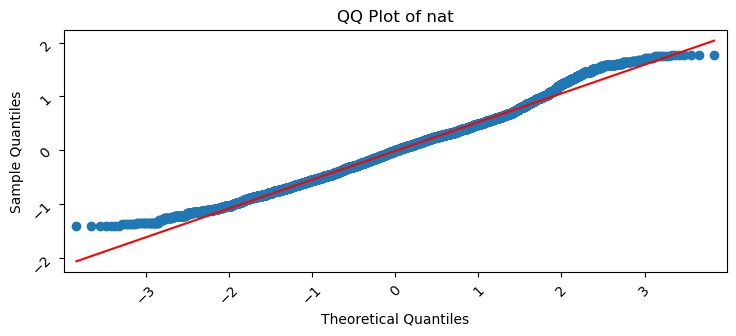

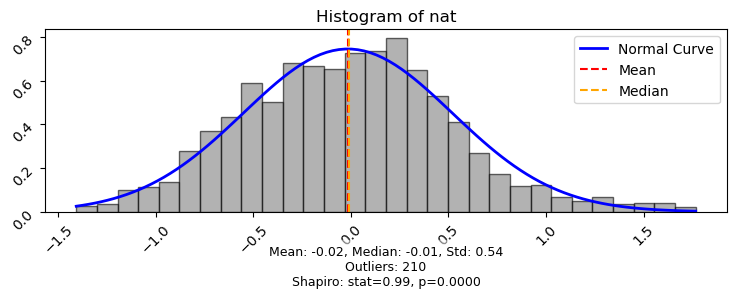

In [136]:
import netCDF4 as nc
import pandas as pd
import datetime

# read
path = '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SST/sst.nc'
ds = nc.Dataset(path)

# get variables
time = ds['TIME'][:].data
nat = ds['NAT'][:].data

# create df
nat_df = pd.DataFrame({'time':time, 'nat':nat})

# create date column based on fact that time is the distance in days from 1800-01-01
start_date = datetime.date(1800, 1, 1)
nat_df['Date'] = nat_df['time'].apply(lambda x: start_date + datetime.timedelta(days=x))
nat_df['Date'] = pd.to_datetime(nat_df['Date'])

nat_df.drop(columns=['time'], inplace=True)

# sst df is missing dates, create range of all dates and merge this to the df
min_date, max_date = nat_df['Date'].min(), nat_df['Date'].max()
date_range = pd.date_range(start=min_date, end=max_date, freq='D')
df_dates = pd.DataFrame(date_range, columns=['Date'])
df_dates['Date'] = pd.to_datetime(df_dates['Date'])

nat_df_all_dates = df_dates.merge(nat_df, on = 'Date', how = 'left')

# back fill the empty days
nat_df_filled = nat_df_all_dates.fillna(method='bfill')


nat_df_filled = nat_df_filled.set_index('Date')
nat_df_filled = nat_df_filled.apply(pd.to_numeric, errors='coerce')

nat_df_filled.index.names = ['Date']

nat_QQ_Plots = Create_QQ_Plot(nat_df_filled)
nat_Distribution_Plots = Create_Hist_Normal_Plot_With_Stats_Outliers(nat_df_filled)



**Nao**

Amount of days with missing values: Year     0.000000
Month    0.000000
NAO      0.012061
dtype: float64

Descriptives of labor participation:

              Year       Month         NAO
count   912.000000  912.000000  901.000000
mean   1987.500000    6.500000   -0.004950
std      21.949448    3.453947    1.021459
min    1950.000000    1.000000   -3.180000
25%    1968.750000    3.750000   -0.750000
50%    1987.500000    6.500000    0.040000
75%    2006.250000    9.250000    0.720000
max    2025.000000   12.000000    3.040000

--------------------------------------------------

Distribution and QQ plots:



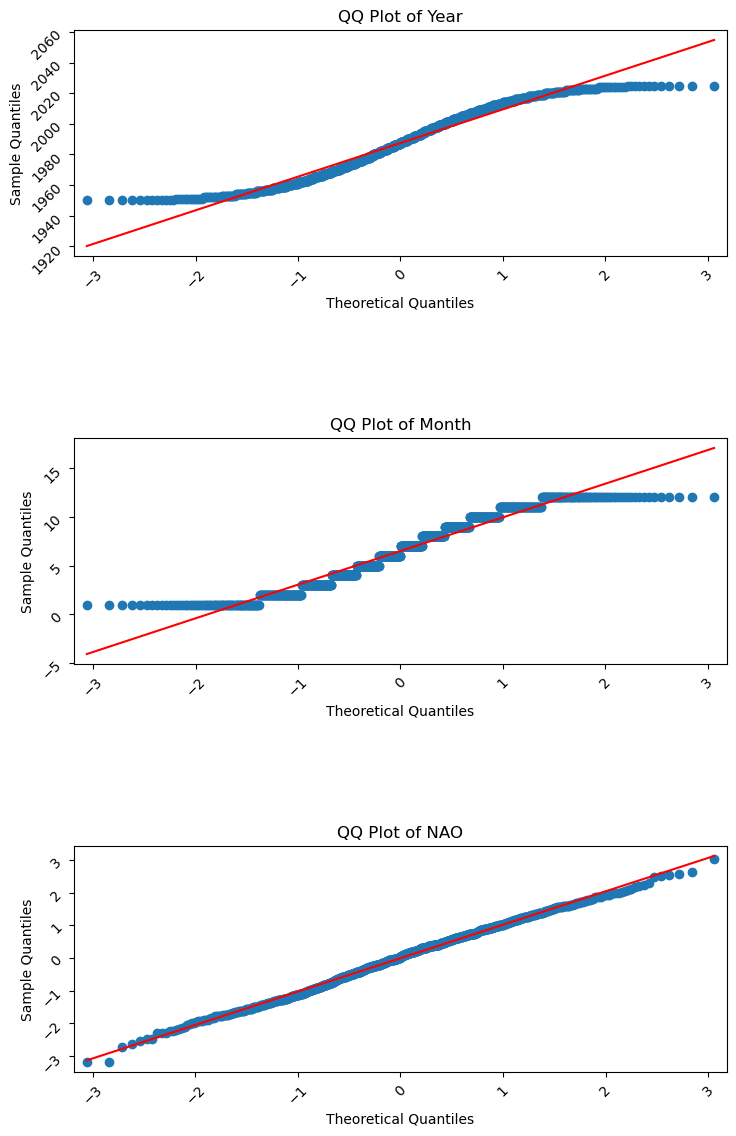

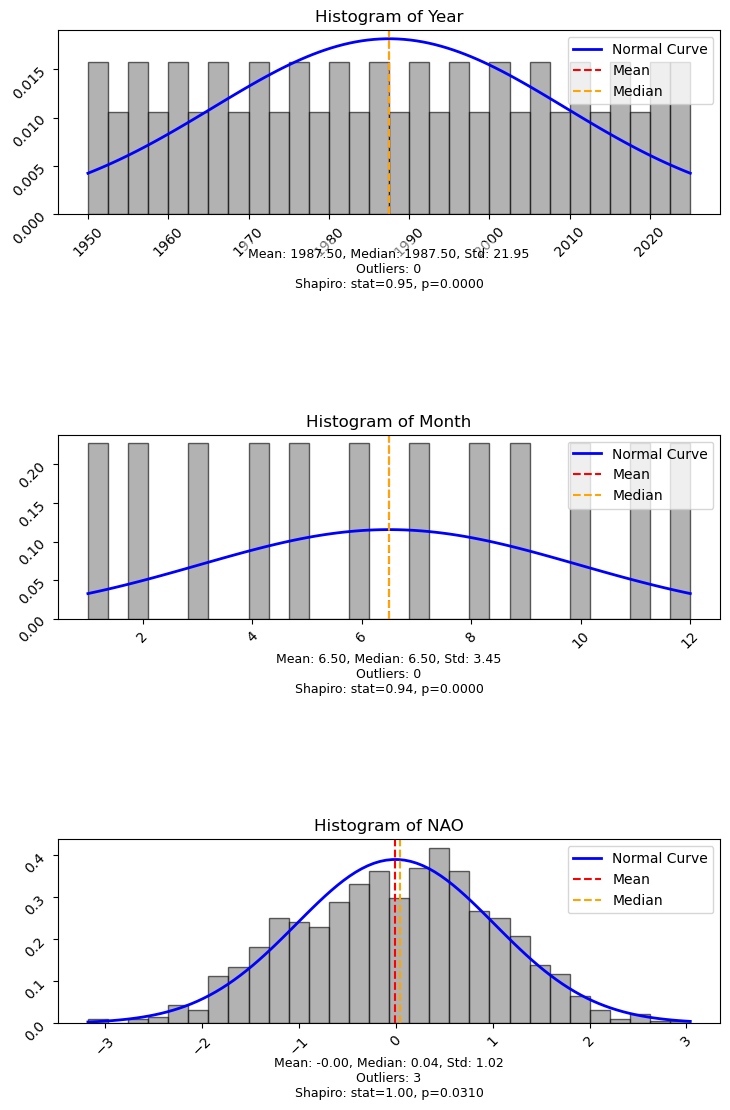

In [208]:

nao_path = '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/NAO.txt'
nao = preprocess_nao(nao_path)

Create_EDA(nao)

**Weather*8

Amount of days with missing values: Date                      0.0
DailyPrecipitation        0.0
MaxHourlyPrecipitation    0.0
HDMaxPrecipitation        0.0
DailyMeanTemperature      0.0
HourlyMinTemperature      0.0
HDMinTemperature          0.0
HourlyMaxTemperature      0.0
HDMaxTemperature          0.0
DailyMeanWindspeed        0.0
MaxHourlyMeanWindspeed    0.0
HDMaxMeanWindspeed        0.0
MinHourlyMeanWindspeed    0.0
HDMinMeanWindspeed        0.0
Month                     0.0
Year                      0.0
Week                      0.0
WeekKey                   0.0
day_of_week               0.0
dtype: float64

Descriptives of labor participation:

                                Date  HDMaxPrecipitation  \
count                           1512         1512.000000   
mean   2023-01-26 11:59:59.999999744            7.007275   
min              2021-01-01 00:00:00            1.000000   
25%              2022-01-13 18:00:00            1.000000   
50%              2023-01-26 12:00:00    

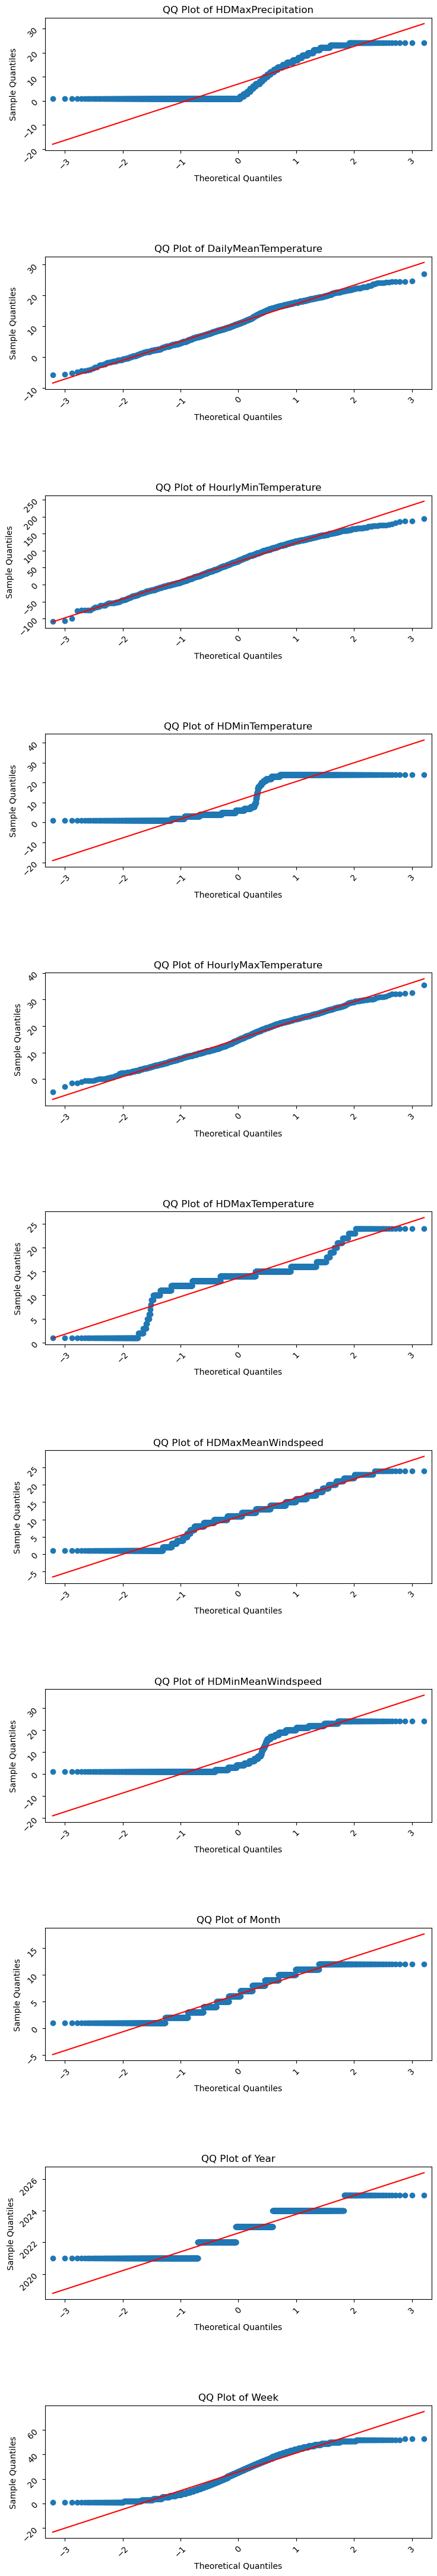

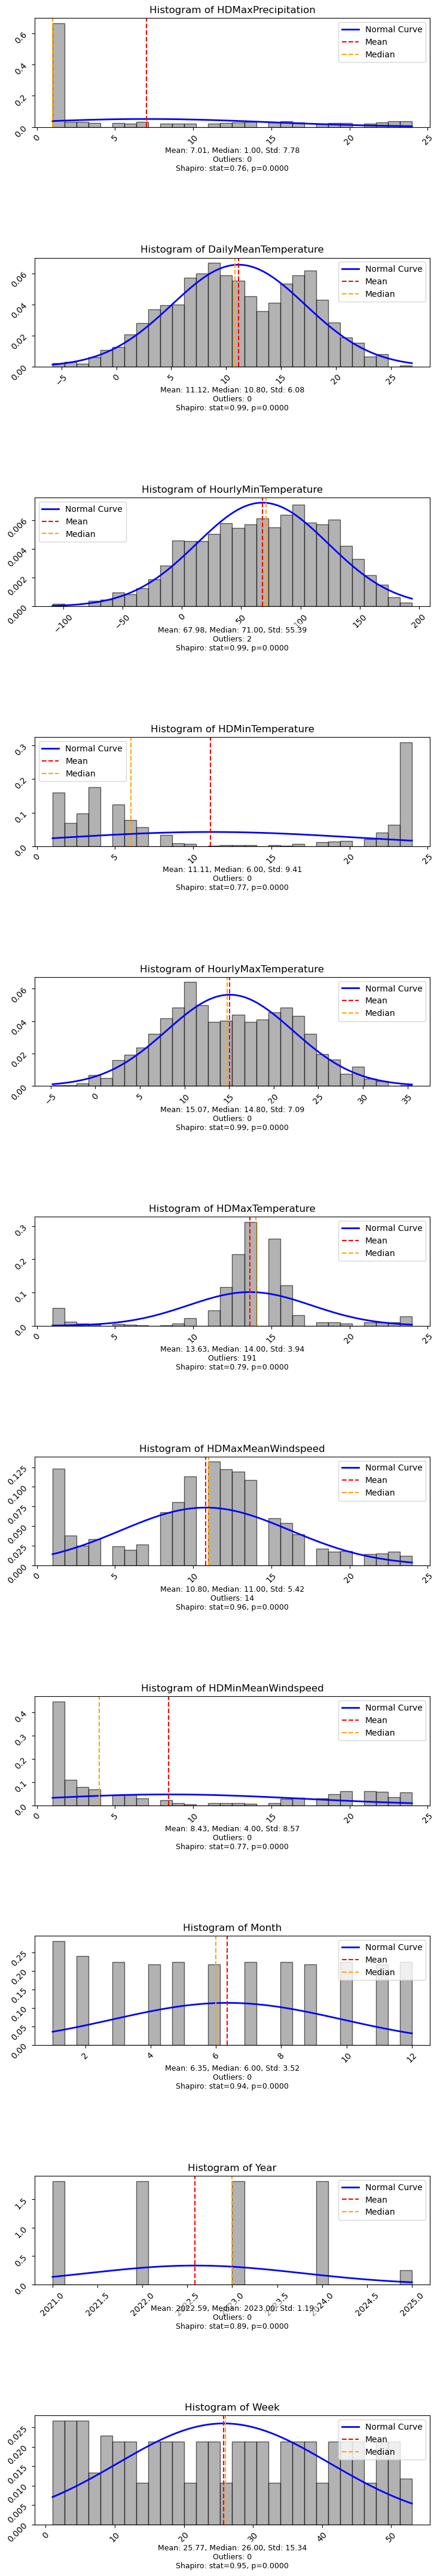

In [209]:
file_path = '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/KNMI/etmgeg_260.txt'
weather = preprocess_weather(file_path)

Create_EDA(weather)

**Energy Prices**

Amount of days with missing values: euro per m3       0.0
euro per m3.1     0.0
euro per m3.2     0.0
euro per kWh      0.0
euro per kWh.1    0.0
euro per kWh.2    0.0
dtype: float64

Descriptives of labor participation:

       euro per m3  euro per m3.1  euro per m3.2  euro per kWh  \
count   186.000000     186.000000     186.000000    186.000000   
mean      0.789032       0.654097       0.311452      0.151968   
std       0.296575       0.227656       0.206715      0.041523   
min       0.553000       0.459000       0.159000      0.049000   
25%       0.630000       0.533000       0.202000      0.131000   
50%       0.662000       0.558000       0.241000      0.151000   
75%       0.809000       0.666000       0.279000      0.160000   
max       1.778000       1.334000       1.104000      0.306000   

       euro per kWh.1  euro per kWh.2  
count      186.000000      186.000000  
mean         0.112000        0.082677  
std          0.040915        0.044402  
min          0.076000  

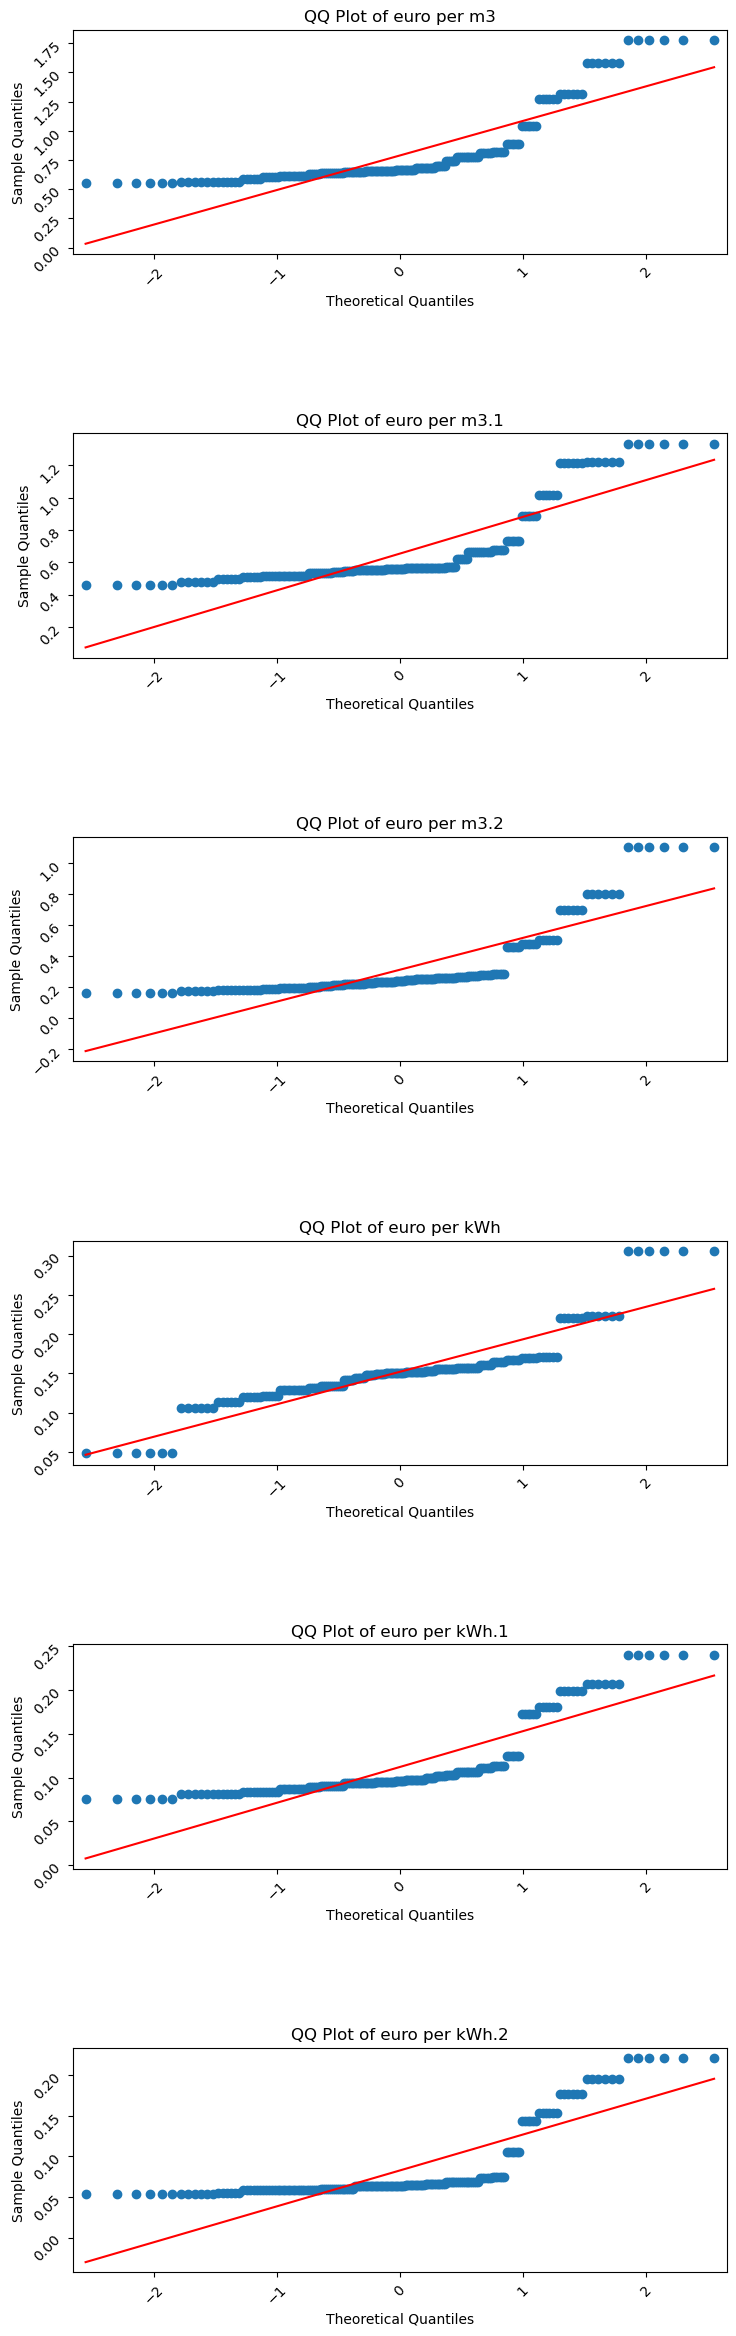

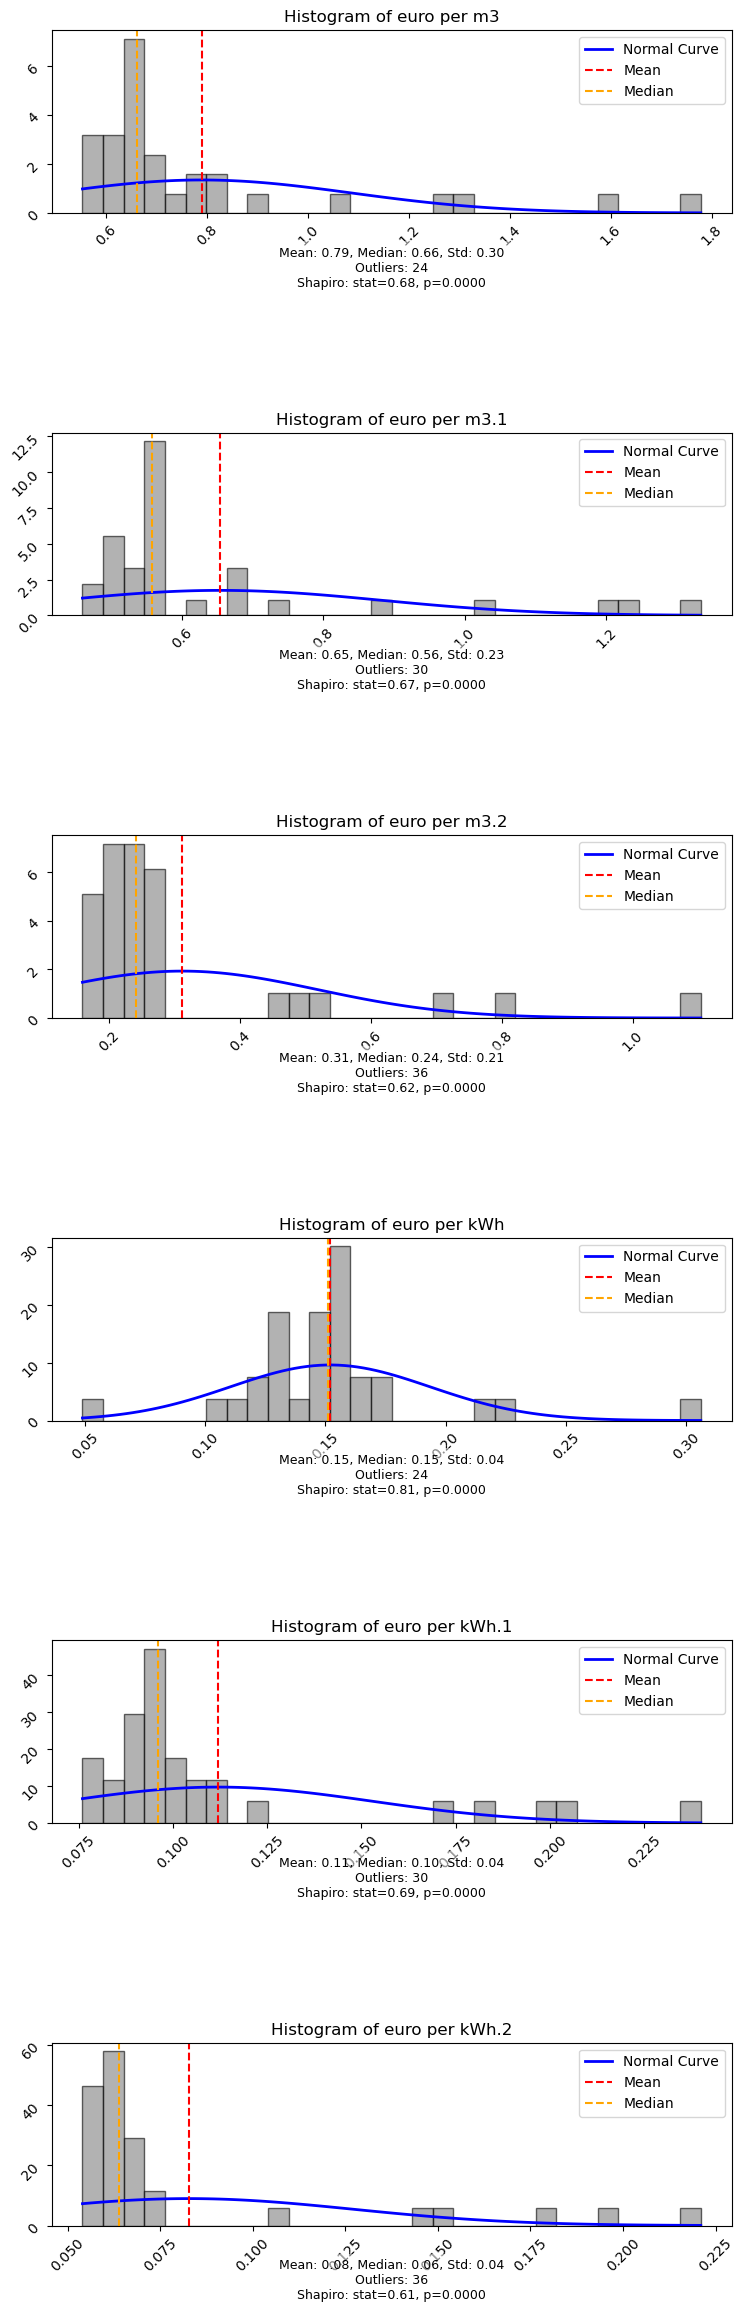

In [139]:
def preprocess_energy_price(energy_prices_path: str) -> pd.DataFrame:
    energy_prices = pd.read_csv(energy_prices_path, delimiter=';')
        # Apply the function to create monthly entries
    energy_prices['Date'] = energy_prices['Perioden'].apply(expand_halfjaar_to_months)

    # Explode the list of months into individual rows
    energy_prices = energy_prices.explode('Date')

    # Convert to datetime and set as index
    energy_prices['Date'] = pd.to_datetime(energy_prices['Date'])
    energy_prices.set_index('Date', inplace=True)

    # Optional: Drop the original 'period' column if no longer needed
    energy_prices = energy_prices.drop(columns=['Perioden','Prijscomponenten'])

    # Convert to numeric
    energy_prices = convert_to_numeric(energy_prices)

    return energy_prices

energy_prices_path = '/Users/ruben/Downloads/Eindverbruikersprijzen_aardgas_en_elektriciteit_23032025_103045.csv'

energy_prices = preprocess_energy_price(energy_prices_path)
Create_EDA(energy_prices)


**SIC**

Amount of days with missing values: date    0.0
sic     0.0
dtype: float64

Descriptives of labor participation:

                                date           sic
count                           4748   4748.000000
mean   2014-03-12 02:37:42.510530816  10144.458111
min              2006-01-01 00:00:00   5445.534727
25%              2011-04-02 18:00:00   8208.467553
50%              2014-07-02 12:00:00  10905.204426
75%              2017-10-01 06:00:00  12044.521888
max              2020-12-31 00:00:00  12694.216693
std                              NaN   2126.292922

--------------------------------------------------

Distribution and QQ plots:



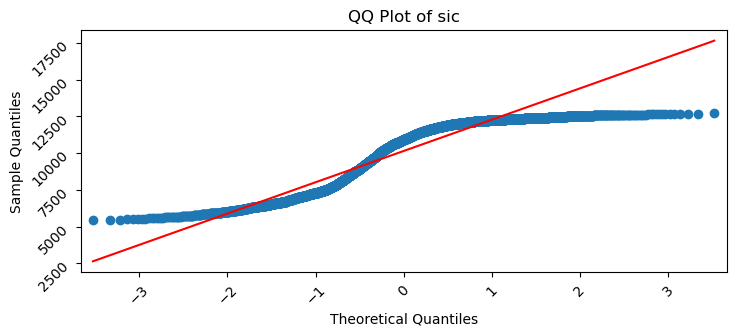

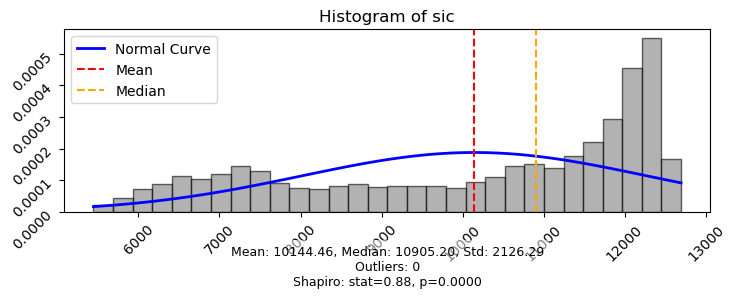

In [141]:
# get paths of sea ice concentration files
sic_paths = [
'/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/1ede5264bd6ecbc3cefa0e2eb5651a88/',
'/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/8e7fc0e0427d9bbbbd4f932132100311',
'/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/9f0afe1ca7db97892fb656304822dd29/',
'/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/717a61014ce7c5e1035ff279ac05004e/',
'/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/b11b2038dfe57c16035b04ef8448ef88/',
 '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/d1a23a892042fa09d03d711914b8f32d/',
 '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/e5ac6ede289daf14a04b4d8f6aad5c27/' ,
'/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/SIC/e66b0b4a5685e0113270a0e05eaa3267/'
]
# create empty dictionary
sic_dict = {}

for path in sic_paths:
  sea_ice_concentration_files = os.listdir(path)

  # iterate through the files, use try expect because not all files work
  for sic_file in sea_ice_concentration_files:
      try:
          # open file as nc dataset
          ds = nc.Dataset(path + sic_file)

          # get time and ice concentration
          time = ds.variables['time'][:]
          ice_conc = ds.variables['ice_conc'][:]

          # create df from ice concentration and select non nans
          df = pd.DataFrame({'sic': ice_conc.flatten()})
          sic = np.array(df[df['sic'].notna()]['sic']).reshape(-1, 1)

          # apply pca to reduce size, we had a lot of values due to multiple longitudes x latitudes
          pca = PCA(n_components=1)
          pca.fit(sic)

          # add to dict
          sic_dict[time[0]] = pca.singular_values_[0]
      except:
          continue
      
# create df from dict
sic_df = pd.DataFrame(list(sic_dict.items()), columns=['time', 'sic'])

# get date from time (time is distance in seconds from 1978-01-01)
sic_df['date'] = sic_df['time'].apply(lambda x: datetime.date(1978, 1, 1) + datetime.timedelta(0, x))
sic_df['date'] = pd.to_datetime(sic_df['date'])

sic_df['year'] = sic_df['date'].dt.year
sic_df['month'] = sic_df['date'].dt.month

sic_df.sort_values('date', inplace=True)
sic_df.reset_index(drop=True, inplace=True)
sic_df = sic_df[['date', 'sic']]
sic_df.set_index('date')
sic_df.index.names = ['Date']

Create_EDA(sic_df)

**Loadconsumptio**

In [142]:
import os
import pandas as pd

base_dir = '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/entsoe/csv'
Load_files = os.listdir(base_dir)

dfs = []

for file in Load_files:
    try:
        file_path = os.path.join(base_dir, file)
        df = pd.read_csv(file_path)
        
        # Process time column
        # Extract start time (first part before ' - ')
        df['Start_Time'] = df['Time (CET/CEST)'].str.split(' - ').str[0]
        
        # Convert to datetime
        df['datetime'] = pd.to_datetime(
            df['Start_Time'],
            format='%d.%m.%Y %H:%M'
        )
        
        # Split into components
        df['Day'] = df['datetime'].dt.day
        df['Month'] = df['datetime'].dt.month
        df['Year'] = df['datetime'].dt.year
        df['Hour'] = df['datetime'].dt.hour
        df['Minute'] = df['datetime'].dt.minute
        
        # Remove original time columns and temporary columns
        df = df.drop(columns=[
            'Time (CET/CEST)',
            'Start_Time',
            'datetime'
        ])
        
        dfs.append(df)
        
    except Exception as e:
        print(f"Skipped {file} due to error: {e}")

# Vertically concatenate all DataFrames
load_df = pd.concat(dfs, ignore_index=True)

# Sort by date descending (newest first)
load_df = load_df.sort_values(
    by=['Year', 'Month', 'Day', 'Hour', 'Minute'],
    ascending=False
).reset_index(drop=True)

load_df = load_df[load_df['Year'] != 2025]
load_df = load_df.drop(columns=['Day-ahead Total Load Forecast [MW] - Netherlands (NL)'])

# load_df.set_index(["Year", "Month", "Day", "Hour"], inplace=True) 
load_df.rename(columns={"Actual Total Load [MW] - Netherlands (NL)": "LoadConsumption"},inplace=True)

# import pandas as pd

# Read and preprocess the Excel file
excel_df = pd.read_excel("/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/entsoe/load_2006_2015.xlsx")
excel_nl = excel_df[excel_df['Country'] == 'NL'].drop(columns=['Country'])

# Melt hourly columns and rename to match load_df's target column
excel_melted = excel_nl.melt(
    id_vars=["Year", "Month", "Day", "Coverage ratio"],
    value_vars=list(range(24)),  # Columns 0-23 as integers
    var_name="Hour",
    value_name="Actual Total Load [MW] - Netherlands (NL)"  # Exact target column name
)
excel_melted["Hour"] = excel_melted["Hour"].astype(int)
excel_melted.rename(columns={"Actual Total Load [MW] - Netherlands (NL)":"LoadConsumption"}, inplace=True)
# excel_melted.set_index(["Year", "Month", "Day", "Hour"], inplace=True) 

# Merge with load_df using OUTER join to include all years
merged_df = pd.merge(
    load_df,
    excel_melted,
    on=["Year", "Month", "Day", "Hour"],
    how="outer",  # Include all years from both datasets
    suffixes=('', '_excel')
)

# Overwrite the original load column with Excel data where available
merged_df["LoadConsumption"] = merged_df["LoadConsumption_excel"].combine_first(
    merged_df["LoadConsumption"]
)

# Clean up redundant columns
merged_df = merged_df.drop(columns=["LoadConsumption_excel"])


merged_df["Minute"] = merged_df["Minute"].fillna(0).astype(int)  # Default to 0 if missing

merged_df = merged_df[merged_df.Year != 2025]
merged_df.head()






LoadConsumption  Day  Month  Year  Hour  Minute  Coverage ratio
0         10215.0    1      1  2006     0       0           100.0
1          9979.0    1      1  2006     1       0           100.0
2          9460.0    1      1  2006     2       0           100.0
3          8833.0    1      1  2006     3       0           100.0
4          8525.0    1      1  2006     4       0           100.0

In [143]:
merged_df.to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/loadconsumption_till_2025.csv')

In [166]:
add_datetime_columns(df_LaborParticipation).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/LaborParticipation.csv')
add_datetime_columns(nat_df_filled).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/sst_processed.csv')
add_datetime_columns(df_ConsumerPriceIndex).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/ConsumerPriceIndex.csv')
add_datetime_columns(df_GdpProductionAndSpending).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/GdpProductionAndSpending.csv')
add_datetime_columns(df_Boughthomes).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/BoughtHomes.csv')
add_datetime_columns(df_Commodities).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/Commodities.csv')
add_datetime_columns(df_PopulationSize).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/PopulatonSize.csv')
add_datetime_columns(nao).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/nao.csv')
add_datetime_columns(weather).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/weather.csv')
add_datetime_columns(energy_prices).to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/energyprices.csv')
merged_df.to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/loadconsumption_till_2025.csv')


In [167]:
def merge_on_common_time_columns(df1, df2):
    # Define the hierarchy of possible merge keys
    df2 = convert_to_numeric(df2)
    possible_keys = ["Year", "Month", "Day", "Hour", "Minute"]
    
    # Find common columns present in both DataFrames
    common_keys = [key for key in possible_keys if key in df1.columns and key in df2.columns]
    if not common_keys:
        raise ValueError("No common time columns (Year/Month/Day) to merge on.")
    
    # Merge using the highest available time granularity
    merged_df = pd.merge(df1, df2, on=common_keys, how="inner")
    return merged_df


## Creating a complete dataset to test

- For some reason my PopulationSize dataframe doesn't want to merge if you have any suggestions feel free to add them as feedback :)

In [197]:
import seaborn as sns

df_LaborParticipation_dt_columns = add_datetime_columns(df_LaborParticipation)
df_Boughthomes_dt_columns = add_datetime_columns(df_Boughthomes)
df_nat_dt_columns = add_datetime_columns(nat_df_filled)
df_ConsumerPriceIndex_dt_columns = add_datetime_columns(df_ConsumerPriceIndex)
df_GdpProductionAndSpending_dt_columns = add_datetime_columns(df_GdpProductionAndSpending)
df_Commodities_dt_columns = add_datetime_columns(df_Commodities)
df_PopulationSize_dt_columns = add_datetime_columns(df_PopulationSize)
df_nao_dt_columns = add_datetime_columns(nao)
df_weather_dt_columns = add_datetime_columns(weather)
df_energy_prices_dt_columns = add_datetime_columns(energy_prices)



CompleteDataset = merge_on_common_time_columns(merged_df, df_LaborParticipation_dt_columns)
CompleteDataset = merge_on_common_time_columns(CompleteDataset, df_Boughthomes_dt_columns)
CompleteDataset = merge_on_common_time_columns(CompleteDataset, df_ConsumerPriceIndex_dt_columns)
CompleteDataset = merge_on_common_time_columns(CompleteDataset, df_GdpProductionAndSpending_dt_columns)
CompleteDataset = merge_on_common_time_columns(CompleteDataset, df_Commodities_dt_columns)
CompleteDataset = merge_on_common_time_columns(CompleteDataset, df_nat_dt_columns)
CompletDataset = merge_on_common_time_columns(CompleteDataset, df_PopulationSize_dt_columns)
CompleteDataset = merge_on_common_time_columns(CompleteDataset, df_energy_prices_dt_columns)

# print(df_PopulationSize_dt_columns.index)
print(df_energy_prices_dt_columns.index)
CompleteCorrelation = CompleteDataset.corr().loc['LoadConsumption']
SortedCorrrelation = CompleteCorrelation.sort_values(ascending=False)
SortedCorrrelation.to_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/CompleteCorrelation.csv')




DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01'],
              dtype='datetime64[ns]', name='Date', length=186, freq=None)


In [198]:
def correlation_analys(path: str, EnergyPrices, start_date: str = None):
    try:
        df = pd.read_csv(path,index_col='Date')
    except:
        df = pd.read_csv(path)
    df.index = pd.to_datetime(df.index)
    energy_prices.index = pd.to_datetime(energy_prices.index)
    if start_date:
        df = df[pd.to_datetime(df.index) >= pd.to_datetime(start_date)] 
        EnergyPrices = EnergyPrices[pd.to_datetime(EnergyPrices.index) >= pd.to_datetime(start_date)]


    df = merge_on_common_time_columns(EnergyPrices, df).head(5)
    df.set_index(["Year", "Month", "Day", "Hour", "Minute"], inplace=True) 
    corr = df.corr("pearson")
    return corr

In [199]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def calculate_correlations_with_pvalues(CompleteDataset, target_column='LoadConsumption'):
    """
    Calculate Pearson correlations with p-values for a target column against all other columns.
    
    Args:
        CompleteDataset (pd.DataFrame): DataFrame containing all variables
        target_column (str): Column name to calculate correlations against
        
    Returns:
        pd.DataFrame: Sorted correlations with p-values
    """
    # Calculate correlations and p-values
    correlations = []
    pvalues = []
    
    for col in CompleteDataset.columns:
        if col != target_column:
            # Drop NA pairs for valid correlation calculation
            clean_data = CompleteDataset[[target_column, col]].dropna()
            if len(clean_data) < 2:
                corr = np.nan
                pval = np.nan
            else:
                corr, pval = pearsonr(clean_data[target_column], clean_data[col])
            correlations.append(corr)
            pvalues.append(pval)
        else:
            correlations.append(1.0)  # Correlation with self
            pvalues.append(0.0)       # P-value with self

    # Create DataFrame with results
    result_df = pd.DataFrame({
        'Variable': CompleteDataset.columns,
        'Correlation': correlations,
        'P_Value': pvalues
    }).set_index('Variable')

    # Sort by absolute correlation value descending
    sorted_df = result_df.reindex(
        result_df['Correlation'].abs().sort_values(ascending=False).index
    )
    
    return sorted_df


# Calculate correlations with p-values
correlation_results = calculate_correlations_with_pvalues(CompleteDataset)

# Save to CSV
correlation_results.to_csv(
    '/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/CompleteCorrelation.csv',
    index=True
)


# Analysis between datasets

After the preprocessing and simple analyses to see wether the datasets are healthy or not the interactions between the different datasets will be explored. 

## Analysis 1 -  Correlation between Socio Economic Predictors and LoadConsumption



In [200]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go


In [201]:
import pandas as pd
import numpy as np
import plotly.express as px

# Load precomputed correlations (exclude self‑correlation)
corr_df = (
    pd.read_csv('/Users/ruben/Documents/GitHub/MsCThesisRubenCuriel2024/Data/processed_data/CompleteCorrelation.csv')
      .query("Variable != 'LoadConsumption'")
)

# Round for display
corr_df[['Correlation','P_Value']] = corr_df[['Correlation','P_Value']].round({'Correlation':2,'P_Value':4})

# Filter significant (p < .05)
sig = corr_df[corr_df['P_Value'] < 0.05]

# Print table of significant correlations
if not sig.empty:
    print("\nSignificant Correlations (p < 0.05):")
    print(sig[['Variable','Correlation','P_Value']].sort_values('Correlation', ascending=False).to_string(index=False))
else:
    print("\nNo significant correlations found.")

# Top 10 positive & negative
top_pos = sig.nlargest(10, 'Correlation')['Variable'].tolist()
top_neg = sig.nsmallest(10, 'Correlation')['Variable'].tolist()

print("\nTop 10 Positive Correlations:", top_pos)
print("Top 10 Negative Correlations:", top_neg)

# Mark significance for plotting
corr_df['Significance'] = np.where(corr_df['P_Value'] < 0.05, 'Significant', 'Not Significant')

# Plotly scatter
fig = px.scatter(
    corr_df,
    x='Correlation',
    y='Variable',
    color='Significance',
    color_discrete_map={'Significant':'green','Not Significant':'red'},
    title='Correlation with LoadConsumption (α = 0.05)',
    hover_data={'P_Value':True},
    category_orders={'Variable': corr_df.sort_values('Correlation')['Variable'].tolist()}
)

fig.update_layout(
    xaxis_title='Correlation Coefficient',
    yaxis_title=None,
    xaxis_range=[-1.1, 1.1],
    height=600
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  hovertemplate="<b>%{y}</b><br>Correlation: %{x:.2f}<br>P‑Value: %{customdata[0]:.4f}<extra></extra>")

fig.show()



Significant Correlations (p < 0.05):
                                                                                                                                            Variable  Correlation  P_Value
                Opbouw bbp vanuit de finale bestedingen|Finale bestedingen|Nationale finale bestedingen|Bruto investeringen in vaste activa|Overheid         0.38   0.0000
                                                                                                                                                Year         0.34   0.0002
                                                                                                                                    CPI | 2015 = 100         0.32   0.0006
                                                                                                                             Gemiddelde verkoopprijs         0.31   0.0011
                                                                                         Prijsindex verkoop

## Analysis 2 -  Baseline Model

In [202]:
df_prophet = CompleteDataset
df_prophet = CompleteDataset.rename(columns={"DateUTC": "ds", "LoadConsumption": "y"})

df_prophet['ds'] = pd.to_datetime(
    df_prophet[['Year', 'Month', 'Day', 'Hour', 'Minute']]
)


train_size = int(0.8 * len(df_prophet))
train_data, test_data = df_prophet[:train_size], df_prophet[train_size:]


df_prophet.head()

y  Day  Month  Year  Hour  Minute  Coverage ratio  \
0  10978.0    1      1  2013     0       0           100.0   
1  10978.0    1      1  2013     0       0           100.0   
2  10978.0    1      1  2013     0       0           100.0   
3  10978.0    1      1  2013     0       0           100.0   
4  10978.0    1      1  2013     0       0           100.0   

   Beroepsbevolking|werkloze beroepsbevolking|Werkloze beroepsbevolking  \
0                                                709                      
1                                                709                      
2                                                709                      
3                                                709                      
4                                                709                      

   Beroepsbevolking|werkloze beroepsbevolking|Kortdurig  \
0                                                477      
1                                                477      
2                                                477      
3                                                477      
4                                                477      

   Beroepsbevolking|werkloze beroepsbevolking|Langdurig of onbekend  ...  \
0                                                232                 ...   
1                                                232                 ...   
2                                                232                 ...   
3                                                232                 ...   
4                                                232                 ...   

   Liquefied natural gas, Japan | ($/mmbtu)  Natural gas index | (2010=100)  \
0                                     15.89                      107.608179   
1                                     15.89                      107.608179   
2                                     15.89                      107.608179   
3                                     15.89                      107.608179   
4                                     15.89                      107.608179   

        nat  euro per m3  euro per m3.1  euro per m3.2  euro per kWh  \
0 -0.248083        0.638           0.55          0.282         0.157   
1 -0.248083        0.638           0.55          0.282         0.157   
2 -0.248083        0.638           0.55          0.282         0.157   
3 -0.248083        0.638           0.55          0.282         0.157   
4 -0.248083        0.638           0.55          0.282         0.157   

   euro per kWh.1  euro per kWh.2         ds  
0           0.094           0.073 2013-01-01  
1           0.094           0.073 2013-01-01  
2           0.094           0.073 2013-01-01  
3           0.094           0.073 2013-01-01  
4           0.094           0.073 2013-01-01  

[5 rows x 59 columns]

In [203]:
def initialize_prophet(regressors, add_seasonality, fourier_weekly, fourier_annual):
    """
    Initialize prophet. Either with specified seasonalities or default. 
    Add regressors if any are entered. 
    """
    if add_seasonality:
        model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=fourier_weekly,
            yearly_seasonality=fourier_annual,
        )

    else:
        model = Prophet()
        
    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)
    
    return model

def run_model(train, test, regressors, add_seasonality, fourier_weekly, fourier_annual):
    """
    Run model.
    Give predictions.
    Calculate RMSE.
    """

    # intialize model
    model = initialize_prophet(regressors, add_seasonality, fourier_weekly, fourier_annual)

    # fit model
    model.fit(train)

    # predict with model 
    forecast = model.predict(test)
    forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

    # calculate rmse
    rmse = sqrt(mean_squared_error(test['y'], forecast['yhat_rounded'][-len(test):]))
    
    corr, p_value = pearsonr(y_test, predictions)
    print(f'Correlation: {corr} and p-value: {p_value} on Test Data')
    return rmse

No regressor, No seasonality

17:18:48 - cmdstanpy - INFO - Chain [1] start processing
17:18:48 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 322.7673142225445
Correlation: 0.49383597425322473 and p-value: 0.01662374261421361 on Test Data


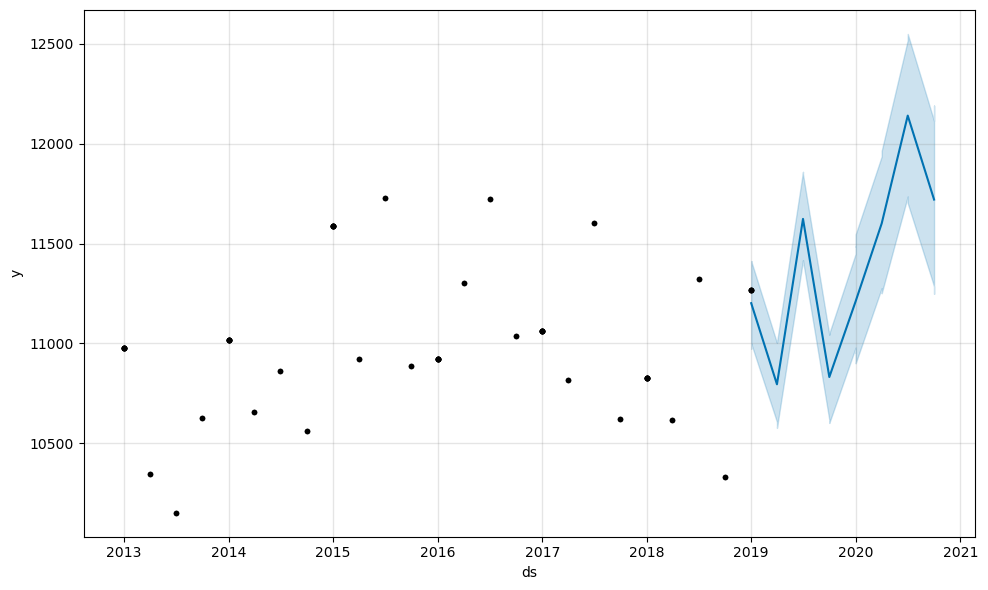

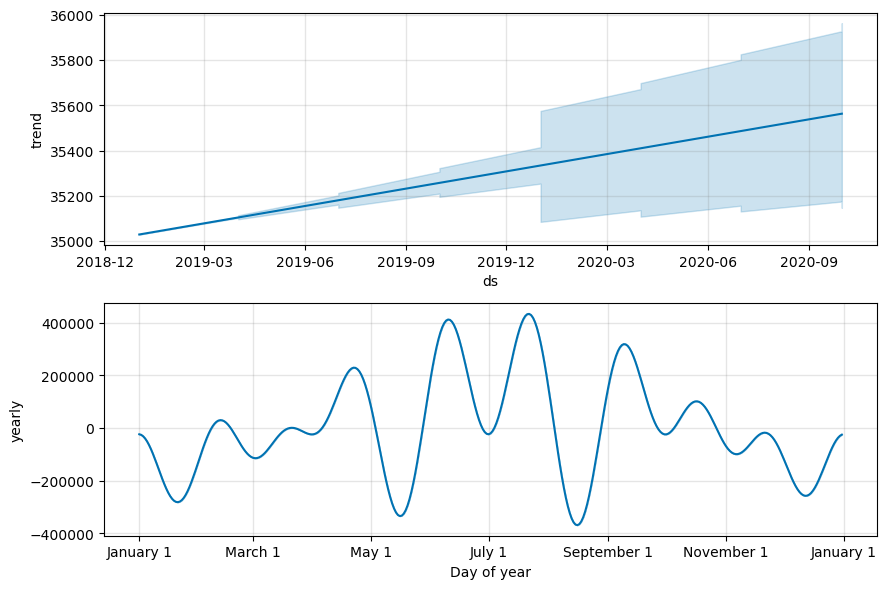

In [204]:
# intialize model
model = initialize_prophet(regressors=[], add_seasonality=False, fourier_weekly=0, fourier_annual=0)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)

fig2 = model.plot_components(forecast)

Top 3 Negative Correlating Regressors

16:15:23 - cmdstanpy - INFO - Chain [1] start processing


16:15:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1102.2625545351864
Correlation: 0.6982098326711429 and p-value: 0.00021153281026008432 on Test Data


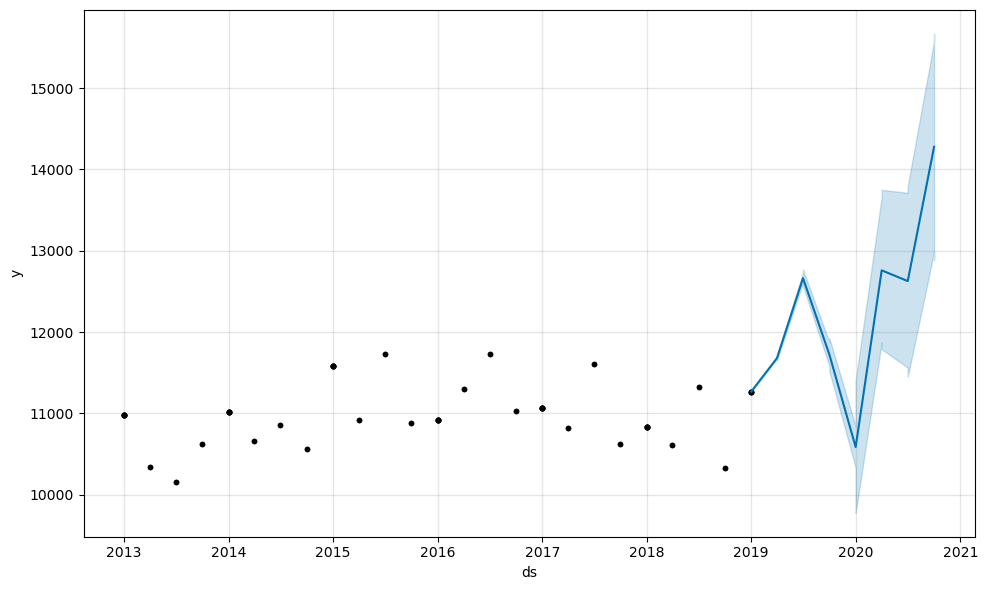

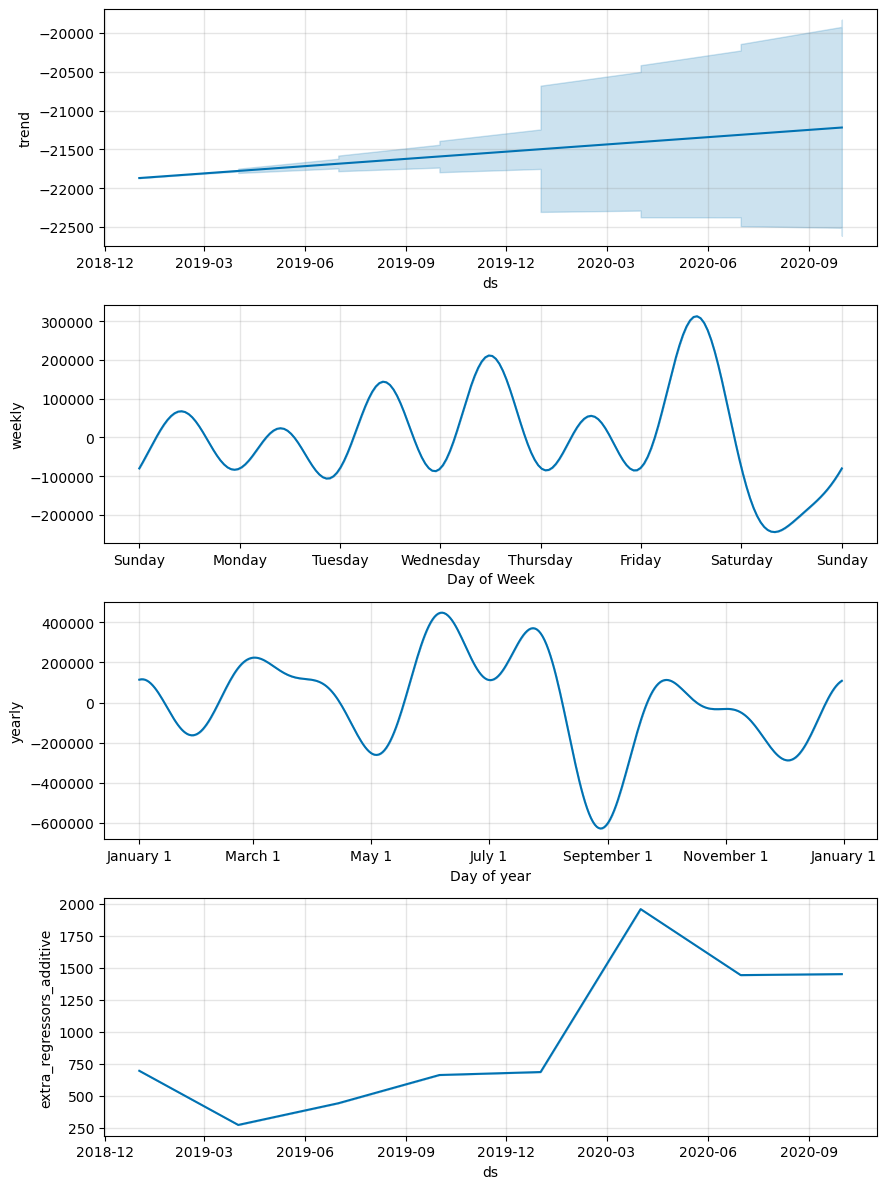

In [29]:
# intialize model
model = initialize_prophet(
    regressors=top_neg[:3],
    add_seasonality=True, 
    fourier_weekly=7, 
    fourier_annual=7
)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

Top 3 positive regressors

In [30]:
print('Top 10 Negative Correlations:', top_neg, '\n')
print('Top 10 Positive Correlations:', top_pos )

Top 10 Negative Correlations: ['Crude oil, WTI | ($/bbl)', 'Crude oil, average | ($/bbl)', 'Crude oil, Brent | ($/bbl)', 'Crude oil, Dubai | ($/bbl)', 'Natural gas, US | ($/mmbtu)', 'Natural gas index | (2010=100)', 'euro per m3.2_y', 'euro per m3.2_x', 'Natural gas, Europe | ($/mmbtu)', 'Coal, South African ** | ($/mt)'] 

Top 10 Positive Correlations: ['Opbouw bbp vanuit de finale bestedingen|Finale bestedingen|Nationale finale bestedingen|Bruto investeringen in vaste activa|Overheid', 'Year', 'CPI | 2015 = 100', 'Gemiddelde verkoopprijs', 'Prijsindex verkoopprijzen|Prijsindex bestaande koopwoningen', 'CPI afgeleid | 2015 = 100', 'Prijsindex verkoopprijzen|Ontwikkeling  t.o.v. een jaar eerder', 'Opbouw bbp vanuit de finale bestedingen|Finale bestedingen|Nationale finale bestedingen|Consumptieve bestedingen|Overheid', 'euro per m3_y', 'euro per m3_x']


16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 565.5364901923929
Correlation: 0.23279907999156152 and p-value: 0.28507955414061303 on Test Data


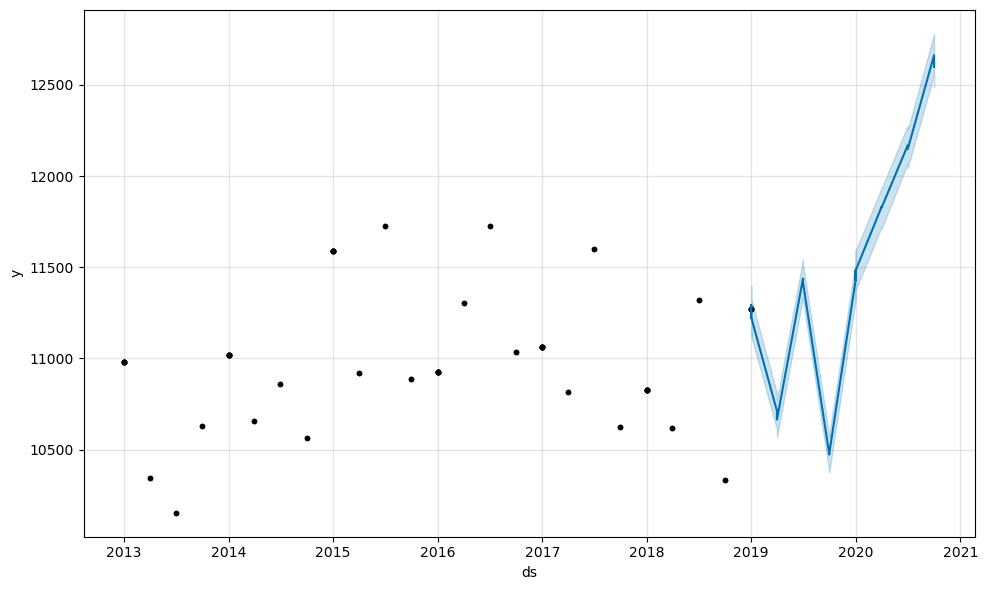

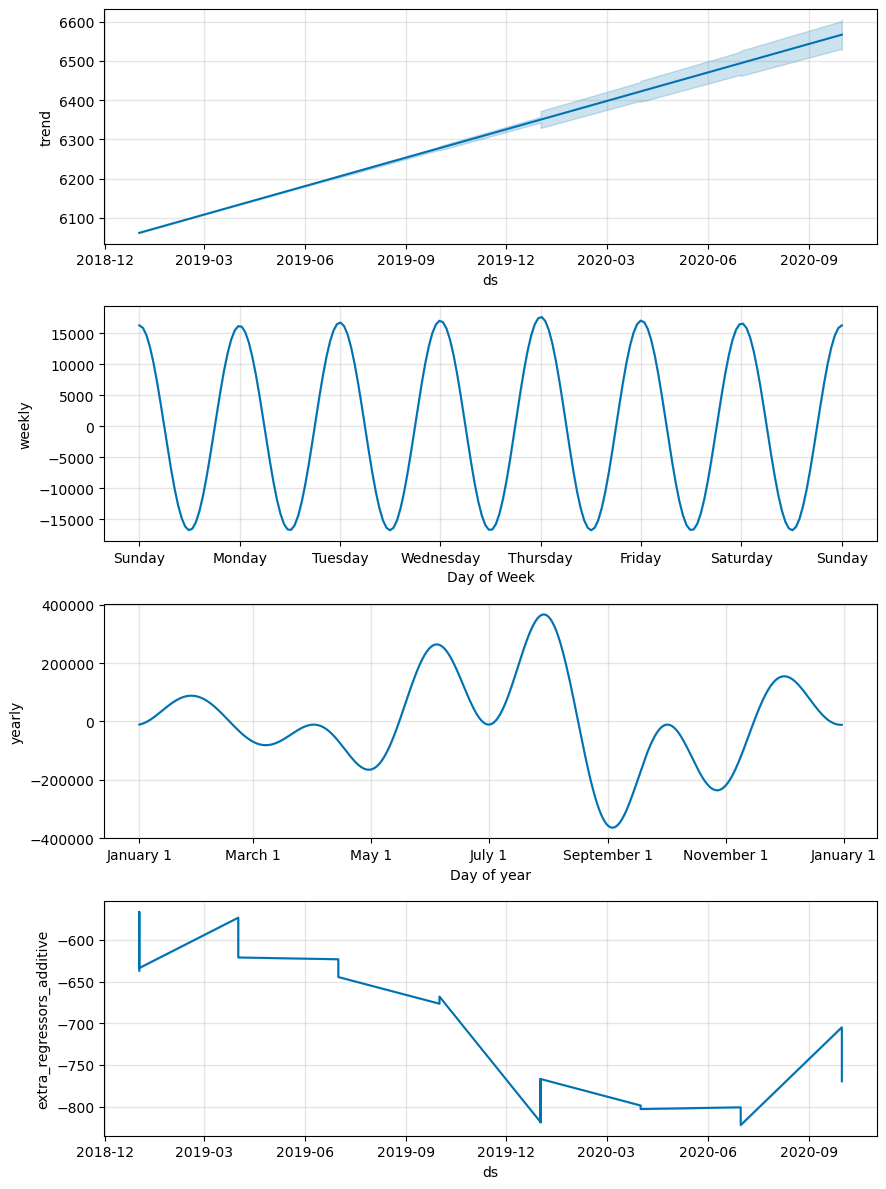

In [31]:
# intialize model
model = initialize_prophet(
    regressors=top_pos[:3],
    add_seasonality=True, 
    fourier_weekly=7, 
    fourier_annual=7
)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

Top 5 neg and pos

16:15:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1195.7753169787593
Correlation: 0.7763323864332282 and p-value: 1.332685357230854e-05 on Test Data


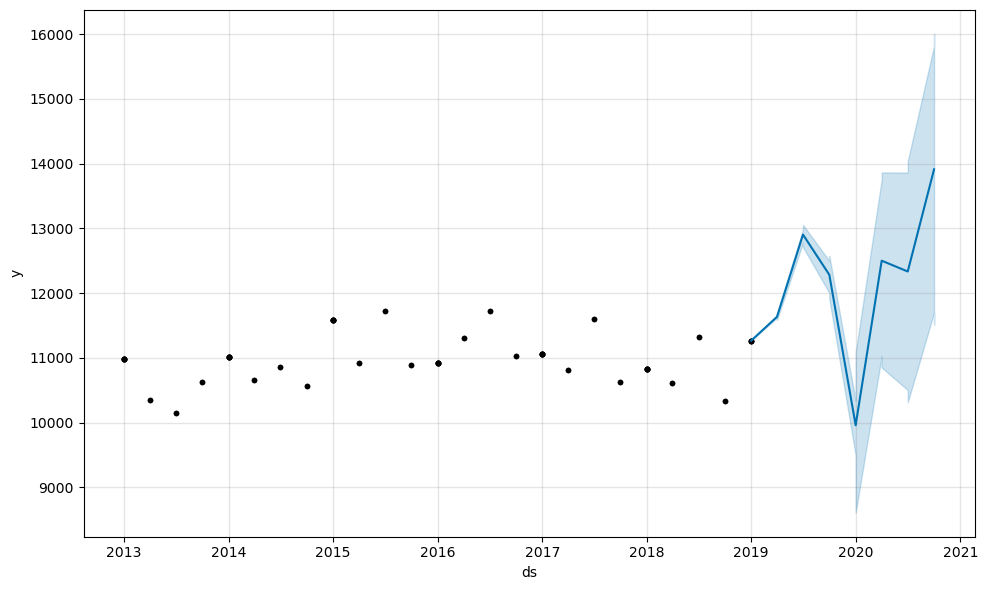

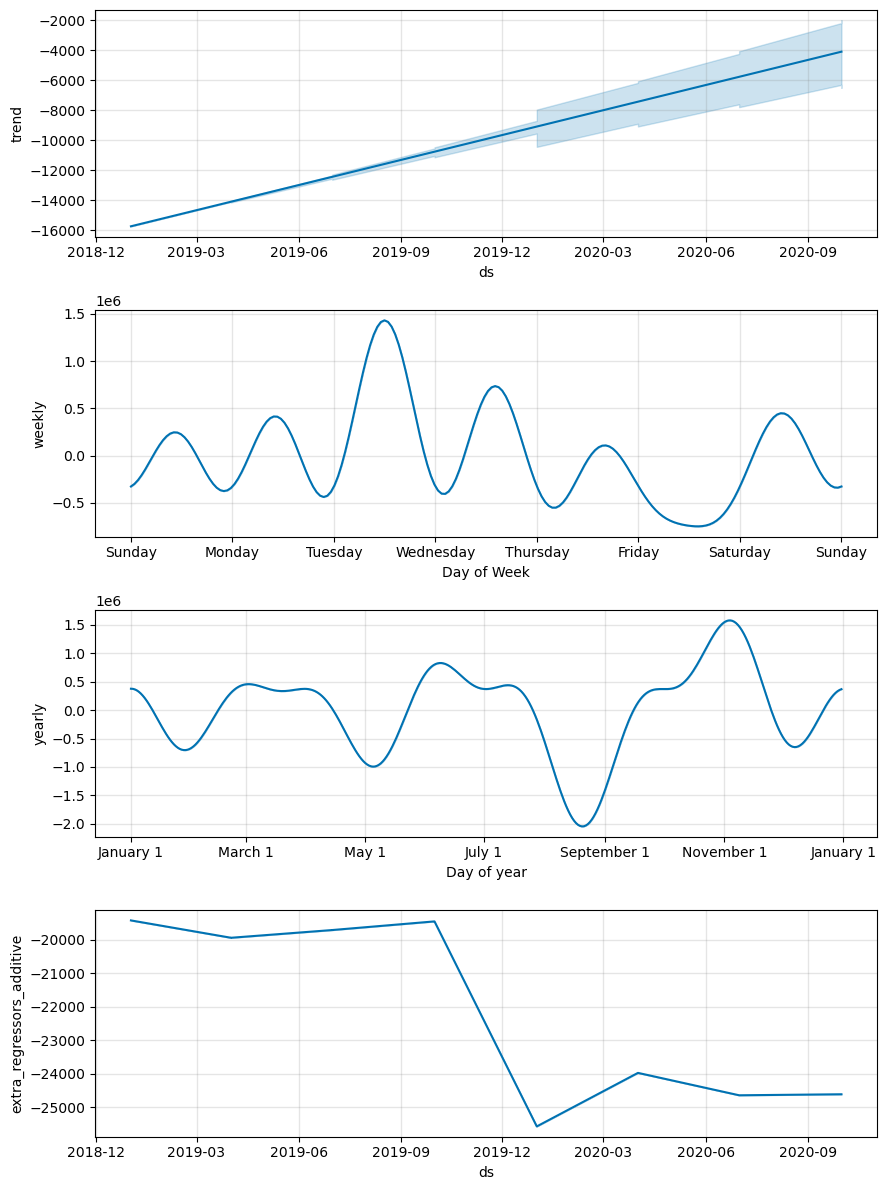

In [32]:
# intialize model
model = initialize_prophet(
    regressors=top_neg[:3]+top_pos[:2],
    add_seasonality=True, 
    fourier_weekly=7, 
    fourier_annual=7
)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)